# Resistance plant gene prediction - Modeling
---

## Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Data preparation and scaling
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

# Modeling Baseline
from sklearn.linear_model import LogisticRegression

# Modeling library
import tensorflow as tf
from tensorflow.keras.models import Model

# Modeling Layers
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.layers import Conv1D, Reshape, MaxPooling1D

# Speed up the model's training
from tensorflow.keras import mixed_precision


# Helper functions
import helper_functions as hf
from Positional_encoding import PositionalEncoding

2024-07-04 20:28:06.955925: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 20:28:06.999261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 20:28:06.999328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 20:28:07.001446: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 20:28:07.009318: I tensorflow/core/platform/cpu_feature_guar

## Data loading

In [2]:
proteins = pd.read_csv('Data/train.csv')

In [3]:
proteins.head()

ID                                           Sequence  Label
0   0  MDSRMDQYEVMEQIGRGAFGAAILVNHKTEKKKYVLKKIRLARQTE...      0
1   4  MAPKAEKKPAEKKPAEEKAGEKAPAAGKKPKAEKRLPASKGEKGGE...      0
2   5  MLELHFEFIDLNQPKMYKFVVCLLTLSFLLLSGLSNTALARVHHES...      0
3   6  MAEPELVNGGVKENKLWKGVFAVSGIMSTLVIYGVLQEKIMRVPYG...      0
4   7  MTSCGCLVLEKVEDHGGEAAGRGRGRLAQGGGGGGGGCGSCAGEWR...      0

In [4]:
proteins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14161 entries, 0 to 14160
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        14161 non-null  int64 
 1   Sequence  14161 non-null  object
 2   Label     14161 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 332.0+ KB


In [5]:
proteins[proteins.duplicated()].shape

(0, 3)

In [6]:
proteins = proteins[proteins['Sequence'].str.len() < 1000].reset_index(drop=True)

In [7]:
labels = pd.DataFrame(proteins['Label'])
labels.head()

Label
0      0
1      0
2      0
3      0
4      0

In [8]:
sequences = proteins['Sequence']
sequences.head()

0    MDSRMDQYEVMEQIGRGAFGAAILVNHKTEKKKYVLKKIRLARQTE...
1    MAPKAEKKPAEKKPAEEKAGEKAPAAGKKPKAEKRLPASKGEKGGE...
2    MLELHFEFIDLNQPKMYKFVVCLLTLSFLLLSGLSNTALARVHHES...
3    MAEPELVNGGVKENKLWKGVFAVSGIMSTLVIYGVLQEKIMRVPYG...
4    MTSCGCLVLEKVEDHGGEAAGRGRGRLAQGGGGGGGGCGSCAGEWR...
Name: Sequence, dtype: object

In [9]:
sequences.shape

(13507,)

## Data Preparation

### Extract Aminos Frequency

In [10]:
aminos = hf.amino_count(sequences)
aminos

M   D    S   R   Q   Y   E   V   I   G  ...   N   H   K   T   C   P  \
0      22  53  123  48  35  16  66  56  55  35  ...  42  23  75  39  21  68   
1       3   2   11   6   2   3  15   7   9  11  ...   3   2  30   7   0   9   
2       2   2    7   5   3   1   3   7   3   5  ...   6   3   5   3   1   4   
3      10   9   27   6  13  15  12  31  19  22  ...  13   5  22  24  10  15   
4       9  21   28  20   9   8  19  27  19  43  ...  11  10  17  10   6  11   
...    ..  ..  ...  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
13502   4   4    7   2   2   3  12   5   2   5  ...   3   1  11   5   0   3   
13503  10  23   42  30   7  13  21  26   6  36  ...   5   7  12  19  10  34   
13504   4  21   26  19  12  11  23  14   8  26  ...  19  16  21  14  11  16   
13505  16  32   45  38  16  14  23  51  23  46  ...  12   8  15  22   6  25   
13506  14  27   28  26  16  21  29  29  15  44  ...  16  11  34  23   7  16   

       W  X  Z  B  
0      4  0  0  0  
1      0  0  0  0  
2      1  0  0  0  
3      5  0  0  0  
4      5  0  0  0  
...   .. .. .. ..  
13502  2  0  0  0  
13503  6  0  0  0  
13504  4  0  0  0  
13505  8  0  0  0  
13506  3  0  0  0  

[13507 rows x 23 columns]

### Tokenization

#### Single Amino Acid

* Tokenize the sequences on char level

In [11]:
# Tokenize on char level
tokenizer1 = Tokenizer(char_level=True)
tokenizer1.fit_on_texts(sequences)
sequences_1p = tokenizer1.texts_to_sequences(sequences)

# Padd the sequences to match all the length of the biggest
sequences_1p = pad_sequences(sequences_1p, padding='post')

In [12]:
sequences_1p

array([[17,  9,  2, ...,  0,  0,  0],
       [17,  3, 12, ...,  0,  0,  0],
       [17,  1,  6, ...,  0,  0,  0],
       ...,
       [17, 16, 14, ...,  0,  0,  0],
       [17,  3,  3, ...,  0,  0,  0],
       [17,  4, 10, ...,  0,  0,  0]], dtype=int32)

* Max sequence length

In [13]:
len(sequences_1p[0])

997

* Append the frequence of each amino in sequence df

In [14]:
amino_counts = hf.amino_count(sequences_1p)
amino_counts

17  9    2   8   15  16  6   5   10  4   ...  18  7   11  19  12  20  \
0      22  53  123  48  35  16  66  56  55  35  ...  23  75  39  21  68   4   
1       3   2   11   6   2   3  15   7   9  11  ...   2  30   7   0   9   0   
2       2   2    7   5   3   1   3   7   3   5  ...   3   5   3   1   4   1   
3      10   9   27   6  13  15  12  31  19  22  ...   5  22  24  10  15   5   
4       9  21   28  20   9   8  19  27  19  43  ...  10  17  10   6  11   5   
...    ..  ..  ...  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
13502   4   4    7   2   2   3  12   5   2   5  ...   1  11   5   0   3   2   
13503  10  23   42  30   7  13  21  26   6  36  ...   7  12  19  10  34   6   
13504   4  21   26  19  12  11  23  14   8  26  ...  16  21  14  11  16   4   
13505  16  32   45  38  16  14  23  51  23  46  ...   8  15  22   6  25   8   
13506  14  27   28  26  16  21  29  29  15  44  ...  11  34  23   7  16   3   

        0   21  22  23  
0       54   0   0   0  
1      847   0   0   0  
2      916   0   0   0  
3      653   0   0   0  
4      643   0   0   0  
...    ...  ..  ..  ..  
13502  905   0   0   0  
13503  611   0   0   0  
13504  695   0   0   0  
13505  473   0   0   0  
13506  555   0   0   0  

[13507 rows x 24 columns]

In [15]:
len(sequences_1p), len(amino_counts)

(13507, 13507)

In [16]:
sequences_1p = pd.DataFrame(sequences_1p)
sequences_1p.head()

0    1    2    3    4    5    6    7    8    9    ...  987  988  989  990  \
0   17    9    2    8   17    9   15   16    6    5  ...    0    0    0    0   
1   17    3   12    7    3    6    7    7   12    3  ...    0    0    0    0   
2   17    1    6    1   18   13    6   13   10    9  ...    0    0    0    0   
3   17    3    6   12    6    1    5   14    4    4  ...    0    0    0    0   
4   17   11    2   19    4   19    1    5    1    6  ...    0    0    0    0   

   991  992  993  994  995  996  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 997 columns]

In [17]:
sequences_1p = pd.concat([sequences_1p, amino_counts], axis=1)
sequences_1p

0   1   2   3   4   5   6   7   8   9   ...  18  7   11  19  12  20  \
0      17   9   2   8  17   9  15  16   6   5  ...  23  75  39  21  68   4   
1      17   3  12   7   3   6   7   7  12   3  ...   2  30   7   0   9   0   
2      17   1   6   1  18  13   6  13  10   9  ...   3   5   3   1   4   1   
3      17   3   6  12   6   1   5  14   4   4  ...   5  22  24  10  15   5   
4      17  11   2  19   4  19   1   5   1   6  ...  10  17  10   6  11   5   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
13502  17   4   1   7   6   6  13   6   6  18  ...   1  11   5   0   3   2   
13503  17  17  17  17   4   6   4   5   2   2  ...   7  12  19  10  34   6   
13504  17  16  14  14  14  15  16   2  13   2  ...  16  21  14  11  16   4   
13505  17   3   3   8  19   2  10   3  13  17  ...   8  15  22   6  25   8   
13506  17   4  10  19  13   2   3   6   9  15  ...  11  34  23   7  16   3   

        0   21  22  23  
0       54   0   0   0  
1      847   0   0   0  
2      916   0   0   0  
3      653   0   0   0  
4      643   0   0   0  
...    ...  ..  ..  ..  
13502  905   0   0   0  
13503  611   0   0   0  
13504  695   0   0   0  
13505  473   0   0   0  
13506  555   0   0   0  

[13507 rows x 1021 columns]

#### Di-peptide

* Split the sequences per 2 aminos

In [18]:
dipeptide_sequences = hf.split_sequences(sequences, step=2)
pd.DataFrame(dipeptide_sequences[212])

0
0    MD
1    LI
2    AG
3    ES
4    SK
..   ..
473  VF
474  GI
475  WR
476  YS
477  RK

[478 rows x 1 columns]

In [19]:
sequences[212]

'MDLIAGESSKVLRKQGFRSLKLMSVDMEQELGNELEPFGADYGRLDNGLIYYVRRNSKPRMRAALALAVKVGSVLEEEDQRGVAHIVEHLAFSATTRYTNHDIVKFLESIGAEFGPCQNAMTTADETIYELFVPVDKPELLSQAISILAEFSSEIRVSKEDLEKERGAVMEEYRGNRNATGRMQDSHWQLMMEGSKYAERLPIGLEKVIRSVPAATVKQFYQKWYHLCNMAVVAVGDFPDTKTVVDLIKTHFEDKRSSSEPPQIPVFPVPSHEETRFSCFVESEAAGSAVMISYKMPVSDLKTVKDYRDMLAESMFLHALNQRLFKISRRKDPPFFACSVAADVLVARVRLHGFSEREISVVRALMMSEIESAYLERDQVQSTSLRDEYIQHFLHKEPVIGIEYEAQLQKTLLPQISASDVSRYSEKLRTSCGCVIKSMEPKSAATIDHMRNVVSKVNSLEEEKMIAPWDEENIPEEIVSEKPTPGDITHQLEYPEVGVTELTLSNGMQVCYKSTDFLDDQVLFTGFSYGGLSELPESDYISCSMGSTIAGEIGMFGYKPSVLMDMLADLETALQLVYQLFTTNVMPQEEEVGIVMQMAEESVRARERDPYTVFANRVKELNYGNSYFFRPIRISELRKVDPLKACEYFNSCFRDPSTFTVVIVGNLDPTIALPLILQYLGGIPKPPQPVLNFNRDDLKGLPFTFPTKITKEFVRSPMVEAQCSVQLCFPVQLTNGTMIEEIHCIGFLGKLLETKIIQFLRFEHGQIYSAEVSVFLGGNKPSRTADLRGDISVNFSCDPEISSKLVDLALEEIVRLQKEGPSQEDISAILEIEQRAHENGMQENYYWLDRIIRGYQSRVYAGDLGASCKILEEGRLRMRESLAPQTAQAALQRILPHPCKKQYTAVILMPQRSRFGFLSSIFSSRSEGPYIRDTKILAGIAGLGVVVFGIWRYSRK'

In [20]:
len(dipeptide_sequences[212]), len(sequences[212])

(478, 956)

In [21]:
tokenizer2 = Tokenizer(char_level=False)
tokenizer2.fit_on_texts(dipeptide_sequences)
sequences_2p = tokenizer2.texts_to_sequences(dipeptide_sequences)
sequences_2p = pad_sequences(sequences_2p, padding='post')

In [22]:
sequences_2p

array([[256,  57, 256, ...,   0,   0,   0],
       [126, 149,  56, ...,   0,   0,   0],
       [195,  20, 322, ...,   0,   0,   0],
       ...,
       [367, 179, 254, ...,   0,   0,   0],
       [126,  89, 253, ...,   0,   0,   0],
       [227, 321,  75, ...,   0,   0,   0]], dtype=int32)

* Max length

In [23]:
len(sequences_2p[0])

499

* Append the frequence of each amino in sequence_2p df

In [24]:
amino_counts = hf.amino_count(sequences_2p)
amino_counts

256  57   339  68   188  228  84   50   123  3    ...  457  458  459  \
0        2    7    1    2    2    1    1    1    1    2  ...    0    0    0   
1        0    1    0    0    0    0    0    0    0    2  ...    0    0    0   
2        0    1    0    0    0    0    0    0    0    0  ...    0    0    0   
3        0    0    1    0    0    1    0    0    2    1  ...    0    0    0   
4        0    3    0    1    0    0    4    0    0    3  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
13502    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
13503    0    1    0    0    0    0    1    1    0    5  ...    0    0    0   
13504    0    0    1    0    0    1    0    0    0    1  ...    0    0    0   
13505    1    2    1    0    0    0    0    2    1    1  ...    0    0    0   
13506    1    0    1    3    0    0    1    1    3    1  ...    0    0    0   

       460  461  462  463  464  465  466  
0        0    0    0    0    0    0    0  
1        0    0    0    0    0    0    0  
2        0    0    0    0    0    0    0  
3        0    0    0    0    0    0    0  
4        0    0    0    0    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  
13502    0    0    0    0    0    0    0  
13503    0    0    0    0    0    0    0  
13504    0    0    0    0    0    0    0  
13505    0    0    0    0    0    0    0  
13506    0    0    0    0    0    0    0  

[13507 rows x 467 columns]

In [25]:
len(sequences_2p), len(amino_counts)

(13507, 13507)

In [26]:
sequences_2p = pd.DataFrame(sequences_2p)
sequences_2p.head()

0    1    2    3    4    5    6    7    8    9    ...  489  490  491  492  \
0  256   57  256  339   68  188  228   84   50  123  ...    0    0    0    0   
1  126  149   56   36  104   38  135   56   38   35  ...    0    0    0    0   
2  195   20  322  171  132  101  240  276  252  130  ...    0    0    0    0   
3  126  200   20  159    6   66  144   19  343   39  ...    0    0    0    0   
4  295  258  282   10   16   88   72  237   76    3  ...    0    0    0    0   

   493  494  495  496  497  498  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 499 columns]

In [27]:
sequences_2p = pd.concat([sequences_2p, amino_counts], axis=1)
sequences_2p

0    1    2    3    4    5    6    7    8    9    ...  457  458  459  \
0      256   57  256  339   68  188  228   84   50  123  ...    0    0    0   
1      126  149   56   36  104   38  135   56   38   35  ...    0    0    0   
2      195   20  322  171  132  101  240  276  252  130  ...    0    0    0   
3      126  200   20  159    6   66  144   19  343   39  ...    0    0    0   
4      295  258  282   10   16   88   72  237   76    3  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
13502  227   18    9  184  296   56   88  220   44   20  ...    0    0    0   
13503  347  347   76   39    1  115  375  231   31   22  ...    0    0    0   
13504  367  179  254  192   75   82   72   27   11    4  ...    0    0    0   
13505  126   89  253   93  341  318   13  244   27   21  ...    0    0    0   
13506  227  321   75   56  232  361  287  155  193  281  ...    0    0    0   

       460  461  462  463  464  465  466  
0        0    0    0    0    0    0    0  
1        0    0    0    0    0    0    0  
2        0    0    0    0    0    0    0  
3        0    0    0    0    0    0    0  
4        0    0    0    0    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  
13502    0    0    0    0    0    0    0  
13503    0    0    0    0    0    0    0  
13504    0    0    0    0    0    0    0  
13505    0    0    0    0    0    0    0  
13506    0    0    0    0    0    0    0  

[13507 rows x 966 columns]

* Also append per char level the frequence

In [28]:
aminos

M   D    S   R   Q   Y   E   V   I   G  ...   N   H   K   T   C   P  \
0      22  53  123  48  35  16  66  56  55  35  ...  42  23  75  39  21  68   
1       3   2   11   6   2   3  15   7   9  11  ...   3   2  30   7   0   9   
2       2   2    7   5   3   1   3   7   3   5  ...   6   3   5   3   1   4   
3      10   9   27   6  13  15  12  31  19  22  ...  13   5  22  24  10  15   
4       9  21   28  20   9   8  19  27  19  43  ...  11  10  17  10   6  11   
...    ..  ..  ...  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
13502   4   4    7   2   2   3  12   5   2   5  ...   3   1  11   5   0   3   
13503  10  23   42  30   7  13  21  26   6  36  ...   5   7  12  19  10  34   
13504   4  21   26  19  12  11  23  14   8  26  ...  19  16  21  14  11  16   
13505  16  32   45  38  16  14  23  51  23  46  ...  12   8  15  22   6  25   
13506  14  27   28  26  16  21  29  29  15  44  ...  16  11  34  23   7  16   

       W  X  Z  B  
0      4  0  0  0  
1      0  0  0  0  
2      1  0  0  0  
3      5  0  0  0  
4      5  0  0  0  
...   .. .. .. ..  
13502  2  0  0  0  
13503  6  0  0  0  
13504  4  0  0  0  
13505  8  0  0  0  
13506  3  0  0  0  

[13507 rows x 23 columns]

In [29]:
sequences_2p = pd.concat([sequences_2p, aminos], axis=1)
sequences_2p

0    1    2    3    4    5    6    7    8    9  ...   N   H   K   T  \
0      256   57  256  339   68  188  228   84   50  123  ...  42  23  75  39   
1      126  149   56   36  104   38  135   56   38   35  ...   3   2  30   7   
2      195   20  322  171  132  101  240  276  252  130  ...   6   3   5   3   
3      126  200   20  159    6   66  144   19  343   39  ...  13   5  22  24   
4      295  258  282   10   16   88   72  237   76    3  ...  11  10  17  10   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ..  ..  ..   
13502  227   18    9  184  296   56   88  220   44   20  ...   3   1  11   5   
13503  347  347   76   39    1  115  375  231   31   22  ...   5   7  12  19   
13504  367  179  254  192   75   82   72   27   11    4  ...  19  16  21  14   
13505  126   89  253   93  341  318   13  244   27   21  ...  12   8  15  22   
13506  227  321   75   56  232  361  287  155  193  281  ...  16  11  34  23   

        C   P  W  X  Z  B  
0      21  68  4  0  0  0  
1       0   9  0  0  0  0  
2       1   4  1  0  0  0  
3      10  15  5  0  0  0  
4       6  11  5  0  0  0  
...    ..  .. .. .. .. ..  
13502   0   3  2  0  0  0  
13503  10  34  6  0  0  0  
13504  11  16  4  0  0  0  
13505   6  25  8  0  0  0  
13506   7  16  3  0  0  0  

[13507 rows x 989 columns]

#### Tri-peptide

* Split the sequences per 3 aminos

In [30]:
tripeptide_sequences = hf.split_sequences(sequences, step=3)
pd.DataFrame(tripeptide_sequences[500])

0
0    MDA
1    NFE
2    MPP
3    VGG
4    MND
..   ...
179  AKF
180  YGN
181  MFA
182  KLS
183   KE

[184 rows x 1 columns]

In [31]:
sequences[500]

'MDANFEMPPVGGMNDDDDMDFGDGASFLKVGEEKEIQQGLKKKLLKEGEGYETPENGDEVEVHYTGTLLDGTKFDSSRDRATPFKFTLGQGQVIKGWDIGIKTMKKGENAVFTIPAELAYGESGSPPTIPANATLQFDVELLKWDSVKDICKDGGVFKKILAVGEKWENPKDLDEVLVKFEAKLEDGTVVGKSDGVEFTVKDGHFCPALTKAVKTMKKGEKVLLTVKPQYGFGEKGKPASAGEGAVPPNATLEINLELVSWKTVSEVTDDNKVVKKVLKEGDGYERPNEGAVVKVKLIGKLQDGTVFLKKGHGENEEPFEFKTDEEQVVDGLDRAVMKMKKGEVALVTIDPEYAFGSNESQQELAVVPPNSTVTYEVDLLTFDKERESWDMNTEEKIEAASKKKEEGNSKFKGGKYSLASKRYEKAVKFIEYDTSFSEEEKKQAKALKVACNLNDAACKLKLKDYKQAEKLCTKVLELESTNVKALYRRAQAYMELSDLDLAEFDVKKALEIDPNNREVKLEQKRLKEKMKEFNKKEAKFYGNMFAKLSKE'

In [32]:
tokenizer3 = Tokenizer(char_level=False)
tokenizer3.fit_on_texts(tripeptide_sequences)
sequences_3p = tokenizer3.texts_to_sequences(tripeptide_sequences)
sequences_3p = pad_sequences(sequences_3p, padding='post')

In [33]:
sequences_3p

array([[2109, 5723, 5998, ...,    0,    0,    0],
       [1845,  749, 1140, ...,    0,    0,    0],
       [2045, 3704, 2843, ...,    0,    0,    0],
       ...,
       [6676, 5322, 2979, ...,    0,    0,    0],
       [ 174, 4038, 2436, ...,    0,    0,    0],
       [3427, 4256, 1161, ...,    0,    0,    0]], dtype=int32)

* Max length

In [34]:
len(sequences_3p[0])

333

In [35]:
sequences_3p = pd.DataFrame(sequences_3p)
sequences_3p

0     1     2     3     4     5     6     7     8     9    ...  323  \
0      2109  5723  5998  2661  3333  1658  1191   370  4953  1618  ...    0   
1      1845   749  1140   383  1713   248   632  2572    55  1140  ...    0   
2      2045  3704  2843  1390  4407  6061  1248  2136   231   218  ...    0   
3      1037   606  1057  1051  2177  4955  1554   181  4627   239  ...    0   
4      3191  5945    50   542  4565   366    55   772   320  2473  ...    0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...  ...   
13502  1491   167  1255  5087  2873   718   814  2168    85  3080  ...    0   
13503  5004  3739   306   611  6279  2853   194   703   138     3  ...    0   
13504  6676  5322  2979   471   966   141   107  1098  5664  3336  ...    0   
13505   174  4038  2436  6985  4164   131   182   135  2435   972  ...    0   
13506  3427  4256  1161  7069  3672   127  5234  1151  2024   396  ...    0   

       324  325  326  327  328  329  330  331  332  
0        0    0    0    0    0    0    0    0    0  
1        0    0    0    0    0    0    0    0    0  
2        0    0    0    0    0    0    0    0    0  
3        0    0    0    0    0    0    0    0    0  
4        0    0    0    0    0    0    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  
13502    0    0    0    0    0    0    0    0    0  
13503    0    0    0    0    0    0    0    0    0  
13504    0    0    0    0    0    0    0    0    0  
13505    0    0    0    0    0    0    0    0    0  
13506    0    0    0    0    0    0    0    0    0  

[13507 rows x 333 columns]

### Train Test Split

#### Single Amino Acid

In [36]:
sequences_1p_train, sequences_1p_test, labels_1p_train, labels_1p_test = train_test_split(sequences_1p, labels, test_size=0.2, random_state=33)

In [37]:
print('Training shapes: ', sequences_1p_train.shape, labels_1p_train.shape)
print('Test shapes: ', sequences_1p_test.shape, labels_1p_test.shape)

Training shapes:  (10805, 1021) (10805, 1)
Test shapes:  (2702, 1021) (2702, 1)


In [38]:
# pd.DataFrame(sequences_1p_train).to_csv('Data/Prepared_Data/1_Amino_Pair/train.csv')
# pd.DataFrame(sequences_1p_test).to_csv('Data/Prepared_Data/1_Amino_Pair/test.csv')

# pd.DataFrame(labels_1p_train).to_csv('Data/Prepared_Data/1_Amino_Pair/labels_train.csv')
# pd.DataFrame(labels_1p_test).to_csv('Data/Prepared_Data/1_Amino_Pair/labels_test.csv')

#### Di-peptide

In [39]:
sequences_2p.columns = sequences_2p.columns.astype(str)

In [40]:
sequences_2p_train, sequences_2p_test, labels_2p_train, labels_2p_test = train_test_split(sequences_2p, labels, test_size=0.2, random_state=33)

In [41]:
print('Training shapes: ', sequences_2p_train.shape, labels_2p_train.shape)
print('Test shapes: ', sequences_2p_test.shape, labels_2p_test.shape)

Training shapes:  (10805, 989) (10805, 1)
Test shapes:  (2702, 989) (2702, 1)


In [42]:
# pd.DataFrame(sequences_2p_train).to_csv('Data/Prepared_Data/2_Amino_Pair/train.csv')
# pd.DataFrame(sequences_2p_test).to_csv('Data/Prepared_Data/2_Amino_Pair/test.csv')

# pd.DataFrame(labels_2p_train).to_csv('Data/Prepared_Data/2_Amino_Pair/labels_train.csv')
# pd.DataFrame(labels_2p_test).to_csv('Data/Prepared_Data/2_Amino_Pair/labels_test.csv')

#### Tri-peptide

In [43]:
sequences_3p_train, sequences_3p_test, labels_3p_train, labels_3p_test = train_test_split(sequences_3p, labels, test_size=0.2, random_state=33)

In [44]:
print('Training shapes: ', sequences_3p_train.shape, labels_3p_train.shape)
print('Test shapes: ', sequences_3p_test.shape, labels_3p_test.shape)

Training shapes:  (10805, 333) (10805, 1)
Test shapes:  (2702, 333) (2702, 1)


In [45]:
# pd.DataFrame(sequences_3p_train).to_csv('Data/Prepared_Data/3_Amino_Pair/train.csv')
# pd.DataFrame(sequences_3p_test).to_csv('Data/Prepared_Data/3_Amino_Pair/test.csv')

# pd.DataFrame(labels_3p_train).to_csv('Data/Prepared_Data/3_Amino_Pair/labels_train.csv')
# pd.DataFrame(labels_3p_test).to_csv('Data/Prepared_Data/3_Amino_Pair/labels_test.csv')

### Balance Training sets

* All tokenised datasets have the same percentages for each label.

In [46]:
labels_1p_train.value_counts() / len(labels_1p_train)

Label
0        0.910689
1        0.089311
Name: count, dtype: float64

In [47]:
labels_2p_train.value_counts() / len(labels_2p_train)

Label
0        0.910689
1        0.089311
Name: count, dtype: float64

In [48]:
labels_3p_train.value_counts() / len(labels_3p_train)

Label
0        0.910689
1        0.089311
Name: count, dtype: float64

* Create balanced datasets with 50/50 percentage of each label

In [49]:
sequences_1p_train_balanced, labels_1p_train_balanced = hf.balance_dataset(sequences_1p_train, labels_1p_train)
sequences_2p_train_balanced, labels_2p_train_balanced = hf.balance_dataset(sequences_2p_train, labels_2p_train)
sequences_3p_train_balanced, labels_3p_train_balanced = hf.balance_dataset(sequences_3p_train, labels_3p_train)

* Single amino tokenization

In [50]:
print(sequences_1p_train_balanced.shape), len(labels_1p_train_balanced)

(1930, 1021)


(None, 1930)

In [51]:
(labels_1p_train_balanced.value_counts()/len(labels_1p_train_balanced)) * 100

Label
0        50.0
1        50.0
Name: count, dtype: float64

* Di-peptide tokenization

In [52]:
print(sequences_2p_train_balanced.shape), len(labels_2p_train_balanced)

(1930, 989)


(None, 1930)

In [53]:
(labels_2p_train_balanced.value_counts()/len(labels_2p_train_balanced)) * 100

Label
0        50.0
1        50.0
Name: count, dtype: float64

* Tri-peptide tokenization

In [54]:
print(sequences_3p_train_balanced.shape), len(labels_3p_train_balanced)

(1930, 333)


(None, 1930)

In [55]:
(labels_3p_train_balanced.value_counts()/len(labels_3p_train_balanced)) * 100

Label
0        50.0
1        50.0
Name: count, dtype: float64

## Mixed precision

* Set up mix precision before modeling to speed up the training

In [56]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-ab9b9fbd-4e42-e44a-c243-d1a9ea6686fe)


In [57]:
tf.config.list_physical_devices()

2024-07-04 20:28:17.888267: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-04 20:28:18.022322: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-04 20:28:18.022366: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [58]:
mixed_precision.set_global_policy(policy='mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


2024-07-04 20:28:18.029700: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [59]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Modeling (1 Aminos Tokenization)

In [60]:
results_df1 = pd.DataFrame(columns=['Tokenization', 'Model', 'Balanced', 'F1-score', 'Mean F1-score'])

In [61]:
sequences_1p_train.shape[1] == sequences_1p_train_balanced.shape[1]

True

In [62]:
sequence_len = sequences_1p_train.shape[1]
voc_size = len(tokenizer1.word_index)
embedding_dim = 500

voc_size

23

### Baseline

* Fit into inbalanced data

In [63]:
lr = LogisticRegression()
lr.fit(sequences_1p_train, labels_1p_train.values.ravel())

/home/konstantinosmpouros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [64]:
predictions = lr.predict(sequences_1p_test)
lr.score(sequences_1p_test, labels_1p_test)

0.9111769059955589

In [65]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      0.99      0.95      2478
    Positive       0.32      0.06      0.10       224

    accuracy                           0.91      2702
   macro avg       0.62      0.53      0.53      2702
weighted avg       0.87      0.91      0.88      2702



In [66]:
results_df1.loc[len(results_df1)] = ['1', 'Baseline', False, hf.f1(labels_1p_test, predictions), hf.mean_f1(labels_1p_test, predictions)]
results_df1

Tokenization     Model  Balanced  F1-score  Mean F1-score
0            1  Baseline     False  0.104478       0.528874

* Fit into balanced data

In [67]:
lr = LogisticRegression()
lr.fit(sequences_1p_train_balanced, labels_1p_train_balanced.values.ravel())

/home/konstantinosmpouros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [68]:
predictions = lr.predict(sequences_1p_test)
lr.score(sequences_1p_test, labels_1p_test)

0.5510732790525537

In [69]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.94      0.54      0.69      2478
    Positive       0.11      0.63      0.19       224

    accuracy                           0.55      2702
   macro avg       0.53      0.59      0.44      2702
weighted avg       0.87      0.55      0.65      2702



In [70]:
results_df1.loc[len(results_df1)] = ['1', 'Baseline', True, hf.f1(labels_1p_test, predictions), hf.mean_f1(labels_1p_test, predictions)]
results_df1

Tokenization     Model  Balanced  F1-score  Mean F1-score
0            1  Baseline     False  0.104478       0.528874
1            1  Baseline      True  0.188629       0.439160

### LSTM

* Model Initialisation

In [71]:
inputs = Input(shape=(sequence_len), name='Input')
embeddings = Embedding(input_dim=voc_size, output_dim=embedding_dim, input_length=sequence_len, name='Embeddings')(inputs)

lstms1 = LSTM(20, name='LSTM_layer_1', return_sequences=True)(embeddings)
x = Dropout(0.1)(lstms1)
lstms2 = LSTM(20, name='LSTM_layer_2', return_sequences=True)(x)
x = Dropout(0.1)(lstms1)
lstms3 = LSTM(20, name='LSTM_layer_3')(x)

dense1 = Dense(50, activation='relu', name='Dense_1')(lstms3)
dense2 = Dense(20, activation='relu', name='Dense_2')(dense1)

outputs = Dense(1, activation=tf.keras.activations.sigmoid, name='Output')(dense2)

2024-07-04 20:28:18.628841: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-04 20:28:18.628956: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-04 20:28:18.629006: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-04 20:28:18.783509: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-04 20:28:18.783578: I external/local_xla/xla/stream_executor

In [72]:
LSTM_model_1 = Model(inputs=inputs, outputs=outputs)
LSTM_model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1021)]            0         
                                                                 
 Embeddings (Embedding)      (None, 1021, 500)         11500     
                                                                 
 LSTM_layer_1 (LSTM)         (None, 1021, 20)          41680     
                                                                 
 dropout_1 (Dropout)         (None, 1021, 20)          0         
                                                                 
 LSTM_layer_3 (LSTM)         (None, 20)                3280      
                                                                 
 Dense_1 (Dense)             (None, 50)                1050      
                                                                 
 Dense_2 (Dense)             (None, 20)                1020  

In [73]:
LSTM_model_1.compile(optimizer=tf.keras.optimizers.AdamW(),
                     loss='binary_focal_crossentropy',
                     metrics=['accuracy'])

* Fit into inbalanced data

In [74]:
history = LSTM_model_1.fit(sequences_1p_train, labels_1p_train, epochs=30, batch_size=25)

Epoch 1/30


2024-07-04 20:28:21.708101: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-07-04 20:28:22.599115: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f274c0062f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-04 20:28:22.599146: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-07-04 20:28:22.605527: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1720114102.673951  208194 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


433/433 [==============================] - 46s 99ms/step - loss: 0.0829 - accuracy: 0.9107
Epoch 2/30
433/433 [==============================] - 45s 105ms/step - loss: 0.0791 - accuracy: 0.9107
Epoch 3/30
433/433 [==============================] - 45s 104ms/step - loss: 0.0782 - accuracy: 0.9132
Epoch 4/30
433/433 [==============================] - 42s 97ms/step - loss: 0.0776 - accuracy: 0.9151
Epoch 5/30
433/433 [==============================] - 43s 99ms/step - loss: 0.0774 - accuracy: 0.9157
Epoch 6/30
433/433 [==============================] - 45s 103ms/step - loss: 0.0771 - accuracy: 0.9146
Epoch 7/30
433/433 [==============================] - 45s 104ms/step - loss: 0.0768 - accuracy: 0.9164
Epoch 8/30
433/433 [==============================] - 44s 101ms/step - loss: 0.0766 - accuracy: 0.9160
Epoch 9/30
433/433 [==============================] - 46s 106ms/step - loss: 0.0765 - accuracy: 0.9154
Epoch 10/30
433/433 [==============================] - 47s 108ms/step - loss: 0.0760 - 

In [75]:
predictions = LSTM_model_1.predict(sequences_1p_test)

85/85 [==============================] - 4s 45ms/step


In [76]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.92079940784604
Mean F1 Score:  0.5886313512898222
F1 Score:  0.21897810218978103
Loss:  0.3762


In [77]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.93      0.99      0.96      2478
    Positive       0.60      0.13      0.22       224

    accuracy                           0.92      2702
   macro avg       0.76      0.56      0.59      2702
weighted avg       0.90      0.92      0.90      2702



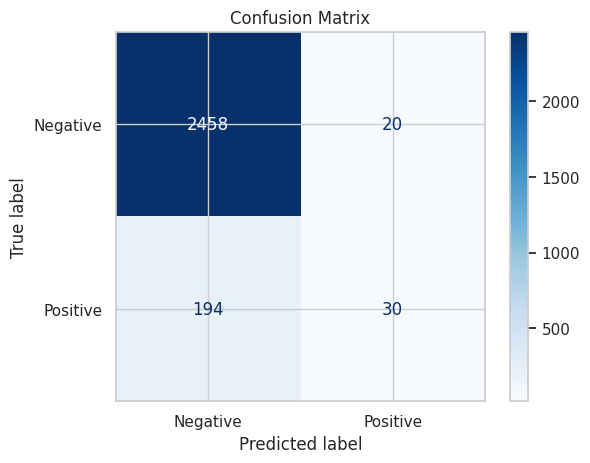

In [78]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/LSTM/lstm_inbalanced_cm')

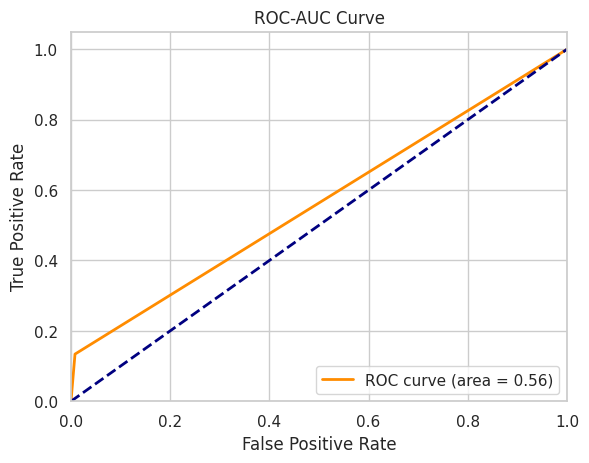

In [79]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/LSTM/lstm_inbalanced_roc_auc')

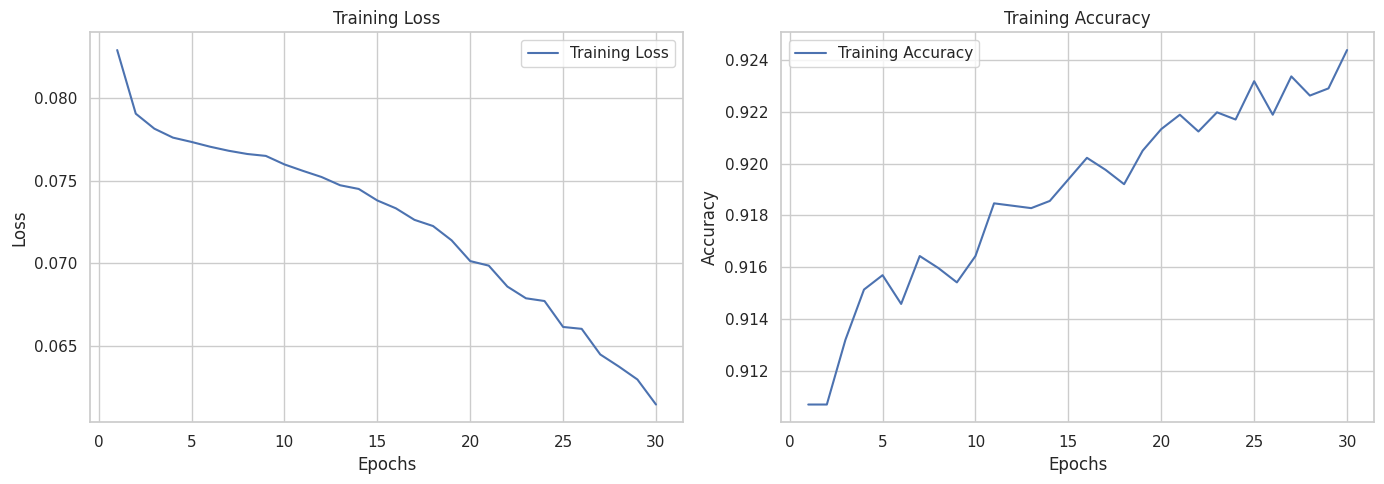

In [80]:
hf.plot_history(history, '1_pair/LSTM/lstm_inbalanced_history')

In [81]:
results_df1.loc[len(results_df1)] = ['1', 'LSTM', False, hf.f1(labels_1p_test, predictions), hf.mean_f1(labels_1p_test, predictions)]
results_df1

Tokenization     Model  Balanced  F1-score  Mean F1-score
0            1  Baseline     False  0.104478       0.528874
1            1  Baseline      True  0.188629       0.439160
2            1      LSTM     False  0.218978       0.588631

* Fit into balanced data

In [82]:
LSTM_model_1 = Model(inputs=inputs, outputs=outputs)
LSTM_model_1.compile(optimizer=tf.keras.optimizers.AdamW(),
                     loss='binary_focal_crossentropy',
                     metrics=['accuracy'])

In [83]:
history = LSTM_model_1.fit(sequences_1p_train_balanced, labels_1p_train_balanced, epochs=30, batch_size=25)

Epoch 1/30
78/78 [==============================] - 10s 109ms/step - loss: 0.1386 - accuracy: 0.6855
Epoch 2/30
78/78 [==============================] - 9s 115ms/step - loss: 0.1193 - accuracy: 0.7565
Epoch 3/30
78/78 [==============================] - 8s 100ms/step - loss: 0.1131 - accuracy: 0.7839
Epoch 4/30
78/78 [==============================] - 10s 124ms/step - loss: 0.1085 - accuracy: 0.7927
Epoch 5/30
78/78 [==============================] - 8s 104ms/step - loss: 0.1060 - accuracy: 0.7959
Epoch 6/30
78/78 [==============================] - 8s 103ms/step - loss: 0.1000 - accuracy: 0.8067
Epoch 7/30
78/78 [==============================] - 8s 99ms/step - loss: 0.0976 - accuracy: 0.8031
Epoch 8/30
78/78 [==============================] - 9s 115ms/step - loss: 0.0972 - accuracy: 0.8176
Epoch 9/30
78/78 [==============================] - 9s 122ms/step - loss: 0.0896 - accuracy: 0.8223
Epoch 10/30
78/78 [==============================] - 9s 112ms/step - loss: 0.0934 - accuracy: 0.825

In [84]:
predictions = LSTM_model_1.predict(sequences_1p_test)

85/85 [==============================] - 5s 55ms/step


In [85]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.5825314581791265
Mean F1 Score:  0.4397640721812074
F1 Score:  0.15695067264573992
Loss:  0.825


In [86]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.93      0.59      0.72      2478
    Positive       0.09      0.47      0.16       224

    accuracy                           0.58      2702
   macro avg       0.51      0.53      0.44      2702
weighted avg       0.86      0.58      0.68      2702



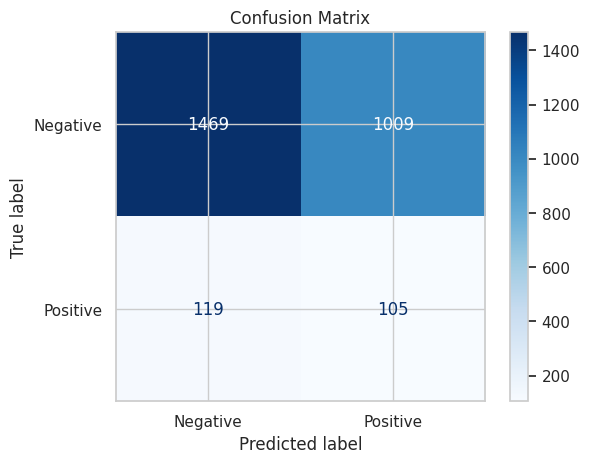

In [87]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/LSTM/lstm_balanced_cm')

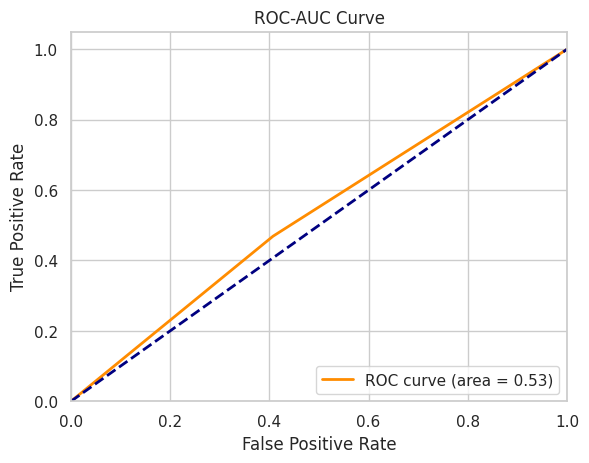

In [88]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/LSTM/lstm_balanced_roc_auc')

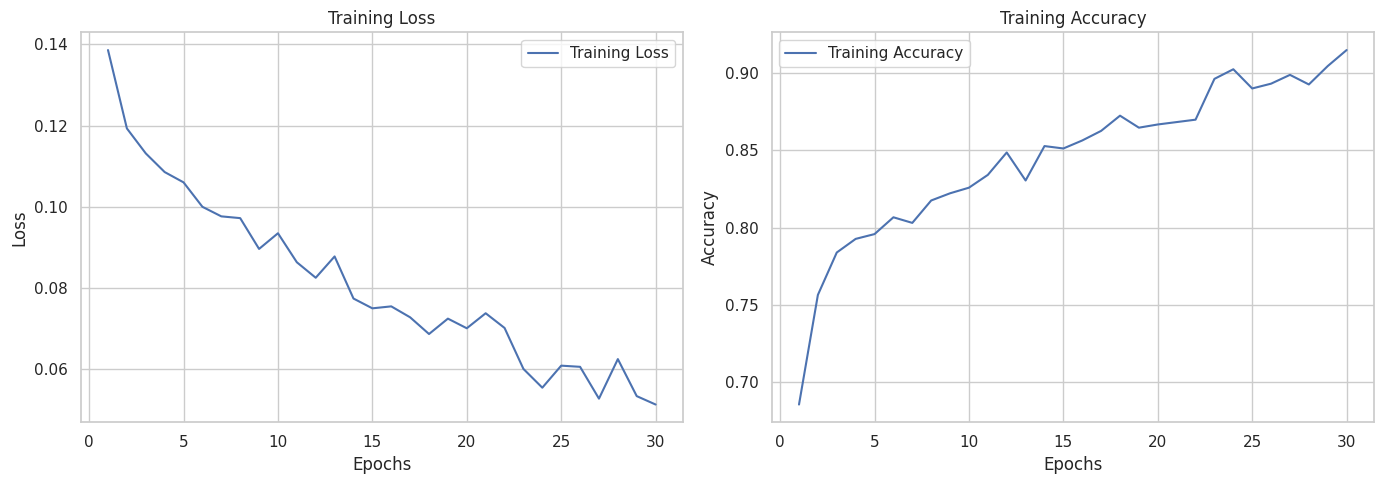

In [89]:
hf.plot_history(history, '1_pair/LSTM/lstm_balanced_history')

In [90]:
results_df1.loc[len(results_df1)] = ['1', 'LSTM', True, hf.f1(labels_1p_test, predictions), hf.mean_f1(labels_1p_test, predictions)]
results_df1

Tokenization     Model  Balanced  F1-score  Mean F1-score
0            1  Baseline     False  0.104478       0.528874
1            1  Baseline      True  0.188629       0.439160
2            1      LSTM     False  0.218978       0.588631
3            1      LSTM      True  0.156951       0.439764

### Transformer

In [91]:
# input_layer = Input(shape=(sequence_len), name='Input')


# x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)
# x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)


# for i in range(2):
#     attention = MultiHeadAttention(num_heads=4, key_dim=embedding_dim, name=f'Attention_{i}')(x, x) 
#     attention = Dropout(0.1, name=f'Dropout1_b{i}')(attention)

#     attention = tf.cast(attention, dtype=tf.float16)
#     x = tf.cast(x, dtype=tf.float16) 
    
#     x = LayerNormalization(epsilon=1e-6, name=f'LayerNorm1_{i}')(x + attention)
    
#     dense = Dense(embedding_dim, activation='relu', name=f'Dense1_b{i}')(x)
#     dense = Dense(embedding_dim, activation='relu', name=f'Dense2_{i}')(dense)
    
#     dense = Dropout(0.1, name=f'Dropout2_b{i}')(dense)
    
#     x = LayerNormalization(epsilon=1e-6, name=f'LayerNorm2_{i}')(x + dense)


# x = GlobalAveragePooling1D(name='GAPooling1D')(x)
# x = Dropout(0.1, name='Dropout')(x)

# outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

* Model Initialisation

In [92]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')


x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)
x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)


attention = MultiHeadAttention(num_heads=10, key_dim=embedding_dim, name='Attention1')(x, x)
attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm2')(x + dense)
x = GlobalAveragePooling1D(name='GAPooling1D')(x)
x = Dropout(0.1, name='Dropout')(x)

outputs_layer = Dense(1, activation=tf.keras.activations.sigmoid, name='Output')(x)

In [93]:
transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_1.compile(optimizer=tf.keras.optimizers.AdamW(),
                      loss='binary_focal_crossentropy',
                      metrics=['accuracy'])

In [94]:
transformer_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 1021)]               0         []                            
                                                                                                  
 Embeddings (Embedding)      (None, 1021, 500)            11500     ['Input[0][0]']               
                                                                                                  
 positional_encoding (Posit  (None, 1021, 500)            0         ['Embeddings[0][0]']          
 ionalEncoding)                                                                                   
                                                                                                  
 Attention1 (MultiHeadAtten  (None, 1021, 500)            1001550   ['positional_encoding[0]

* Fit into inbalanced data

In [95]:
history = transformer_1.fit(sequences_1p_train, labels_1p_train, epochs=30, batch_size=25)

Epoch 1/30
433/433 [==============================] - 123s 278ms/step - loss: 0.1602 - accuracy: 0.8996
Epoch 2/30
433/433 [==============================] - 119s 275ms/step - loss: 0.0867 - accuracy: 0.9107
Epoch 3/30
433/433 [==============================] - 119s 275ms/step - loss: 0.0861 - accuracy: 0.9107
Epoch 4/30
433/433 [==============================] - 119s 275ms/step - loss: 0.0852 - accuracy: 0.9107
Epoch 5/30
433/433 [==============================] - 121s 279ms/step - loss: 0.0836 - accuracy: 0.9107
Epoch 6/30
433/433 [==============================] - 120s 276ms/step - loss: 0.0831 - accuracy: 0.9107
Epoch 7/30
433/433 [==============================] - 120s 276ms/step - loss: 0.0828 - accuracy: 0.9107
Epoch 8/30
433/433 [==============================] - 120s 276ms/step - loss: 0.0830 - accuracy: 0.9107
Epoch 9/30
433/433 [==============================] - 119s 276ms/step - loss: 0.0828 - accuracy: 0.9107
Epoch 10/30
433/433 [==============================] - 119s 276m

In [96]:
predictions = transformer_1.predict(sequences_1p_test)

85/85 [==============================] - 14s 164ms/step


In [97]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.92079940784604
Mean F1 Score:  0.5942339378594667
F1 Score:  0.2302158273381295
Loss:  0.407


In [98]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.93      0.99      0.96      2478
    Positive       0.59      0.14      0.23       224

    accuracy                           0.92      2702
   macro avg       0.76      0.57      0.59      2702
weighted avg       0.90      0.92      0.90      2702



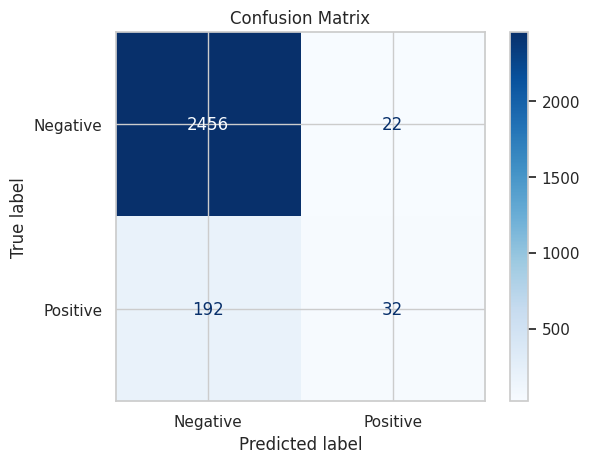

In [99]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/Transformer/transformer_inbalanced_cm')

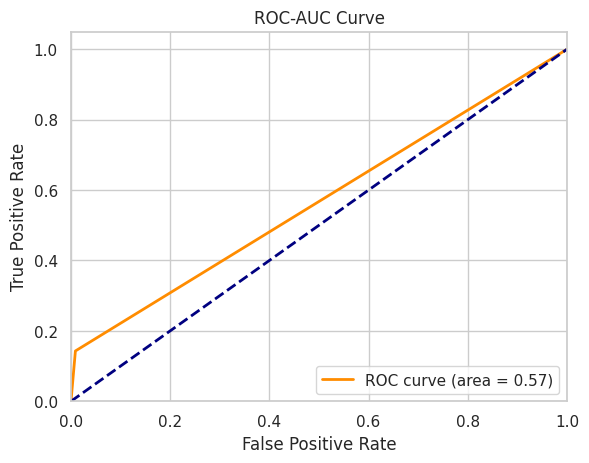

In [100]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/Transformer/transformer_inbalanced_roc_auc')

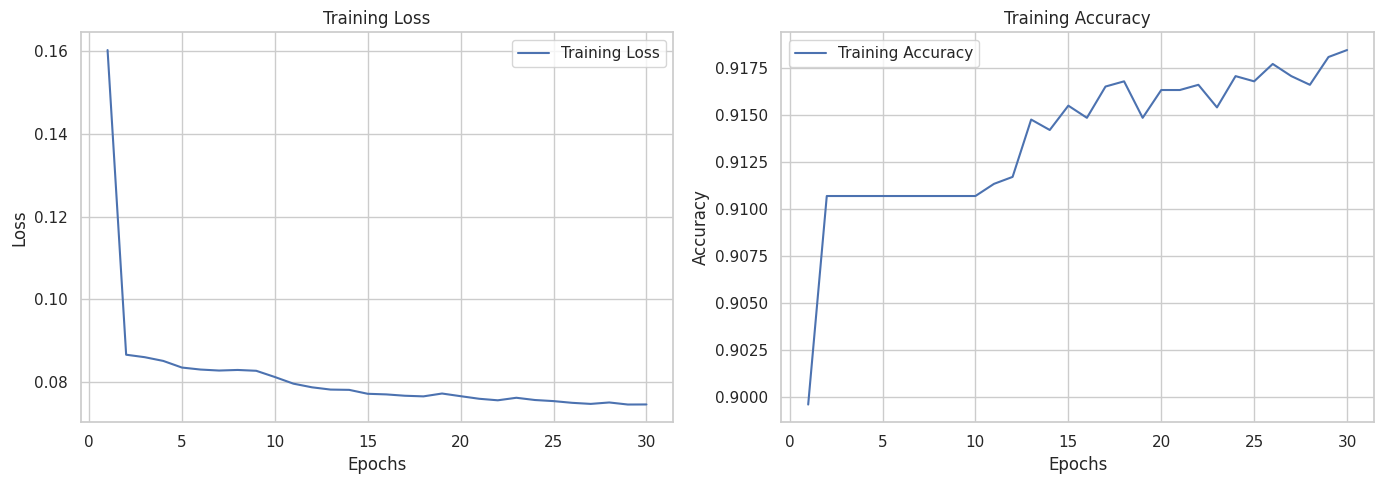

In [101]:
hf.plot_history(history, '1_pair/Transformer/transformer_inbalanced_history')

In [102]:
results_df1.loc[len(results_df1)] = ['1', 'Transformer', False, hf.f1(labels_1p_test, predictions), hf.mean_f1(labels_1p_test, predictions)]
results_df1

Tokenization        Model  Balanced  F1-score  Mean F1-score
0            1     Baseline     False  0.104478       0.528874
1            1     Baseline      True  0.188629       0.439160
2            1         LSTM     False  0.218978       0.588631
3            1         LSTM      True  0.156951       0.439764
4            1  Transformer     False  0.230216       0.594234

* Fit into balanced data

In [103]:
transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_1.compile(optimizer=tf.keras.optimizers.AdamW(),
                      loss='binary_focal_crossentropy',
                      metrics=['accuracy'])

In [104]:
history = transformer_1.fit(sequences_1p_train_balanced, labels_1p_train_balanced, epochs=30, batch_size=25)

Epoch 1/30
78/78 [==============================] - 31s 367ms/step - loss: 0.1633 - accuracy: 0.6202
Epoch 2/30
78/78 [==============================] - 27s 345ms/step - loss: 0.1550 - accuracy: 0.6394
Epoch 3/30
78/78 [==============================] - 27s 340ms/step - loss: 0.1541 - accuracy: 0.6321
Epoch 4/30
78/78 [==============================] - 26s 337ms/step - loss: 0.1523 - accuracy: 0.6477
Epoch 5/30
78/78 [==============================] - 27s 346ms/step - loss: 0.1523 - accuracy: 0.6409
Epoch 6/30
78/78 [==============================] - 27s 341ms/step - loss: 0.1517 - accuracy: 0.6668
Epoch 7/30
78/78 [==============================] - 27s 342ms/step - loss: 0.1508 - accuracy: 0.6611
Epoch 8/30
78/78 [==============================] - 27s 340ms/step - loss: 0.1506 - accuracy: 0.6617
Epoch 9/30
78/78 [==============================] - 27s 341ms/step - loss: 0.1486 - accuracy: 0.6565
Epoch 10/30
78/78 [==============================] - 26s 338ms/step - loss: 0.1478 - accura

In [105]:
predictions = transformer_1.predict(sequences_1p_test)

85/85 [==============================] - 13s 157ms/step


In [106]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.6450777202072538
Mean F1 Score:  0.48968898067106065
F1 Score:  0.20809248554913296
Loss:  0.6646


In [107]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.94      0.65      0.77      2478
    Positive       0.13      0.56      0.21       224

    accuracy                           0.65      2702
   macro avg       0.54      0.61      0.49      2702
weighted avg       0.88      0.65      0.72      2702



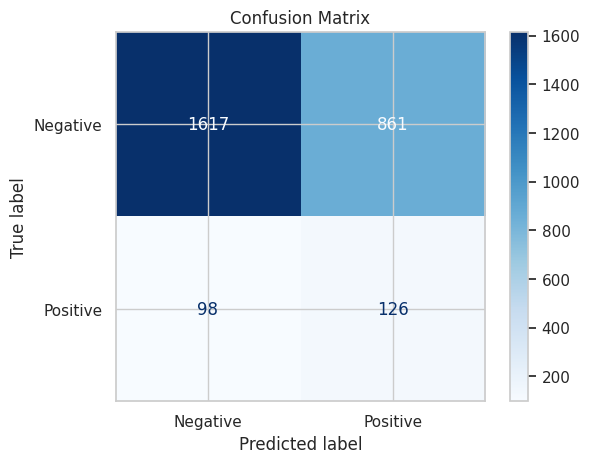

In [108]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/Transformer/transformer_balanced_cm')

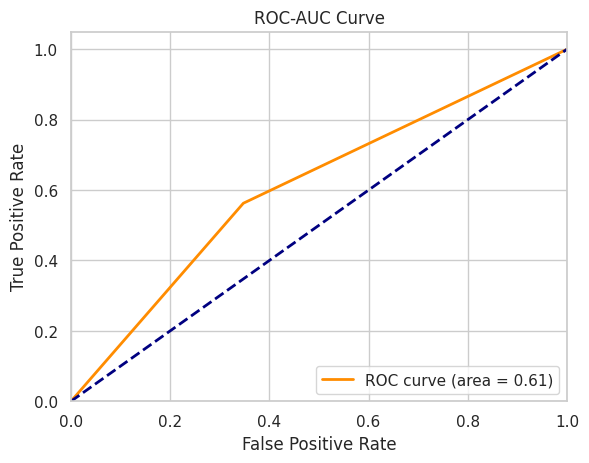

In [109]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/Transformer/transformer_balanced_roc_auc')

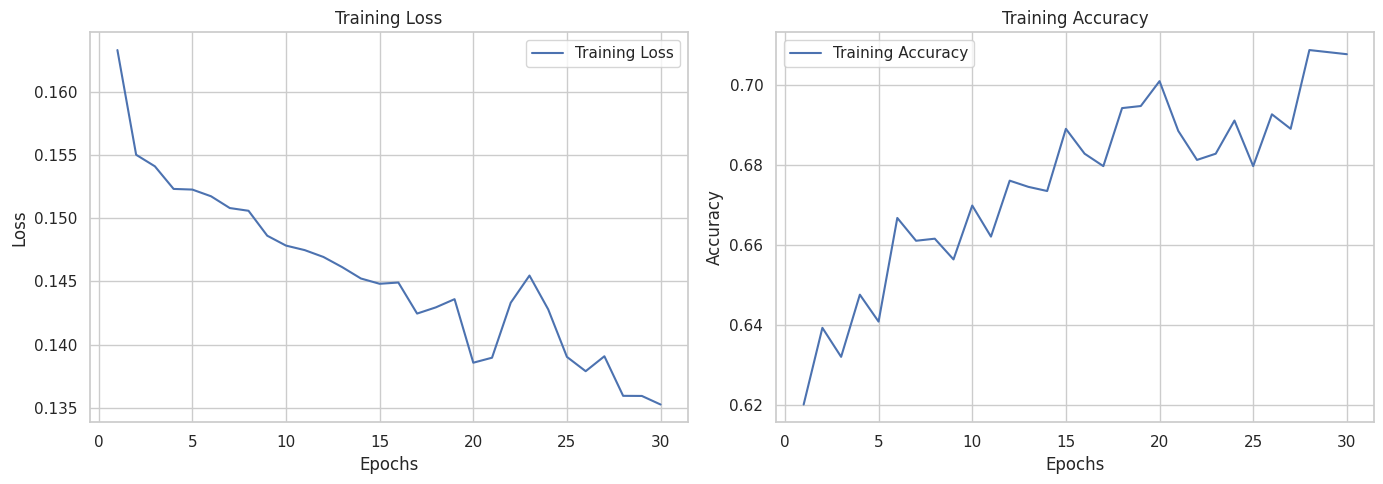

In [110]:
hf.plot_history(history, '1_pair/Transformer/transformer_balanced_history')

In [111]:
results_df1.loc[len(results_df1)] = ['1', 'Transformer', True, hf.f1(labels_1p_test, predictions), hf.mean_f1(labels_1p_test, predictions)]
results_df1

Tokenization        Model  Balanced  F1-score  Mean F1-score
0            1     Baseline     False  0.104478       0.528874
1            1     Baseline      True  0.188629       0.439160
2            1         LSTM     False  0.218978       0.588631
3            1         LSTM      True  0.156951       0.439764
4            1  Transformer     False  0.230216       0.594234
5            1  Transformer      True  0.208092       0.489689

### CNN Transformer

* Model Initialisation

In [112]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')
input_layer = Reshape((sequence_len, 1))(input_layer)

cnn1 = Conv1D(filters=embedding_dim, kernel_size=6, padding='same', activation='relu', name='Conv1D_1')(input_layer)
max_pool1 = MaxPooling1D(pool_size=2, name='MaxPooling1D_1')(cnn1)
# cnn2 = Conv1D(filters=embedding_dim, kernel_size=6, padding='same', activation='relu', name='Conv1D_2')(max_pool1)
# max_pool2 = MaxPooling1D(pool_size=2, name='MaxPooling1D_2')(cnn2)

x = PositionalEncoding(position=sequence_len // 2, d_model=embedding_dim)(max_pool1)


attention = MultiHeadAttention(num_heads=10, key_dim=embedding_dim, name='Attention_1')(x, x)
attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm_1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense_1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense_2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm_2')(x + dense)
x = GlobalAveragePooling1D(name='GAPooling1D')(x)
x = Dropout(0.1, name='Dropout')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [113]:
cnn_transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
cnn_transformer_1.compile(optimizer=tf.keras.optimizers.AdamW(),
                          loss="binary_focal_crossentropy",
                          metrics=['accuracy'])

In [114]:
cnn_transformer_1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1021, 1)]            0         []                            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 1021, 500)            3500      ['input_1[0][0]']             
                                                                                                  
 MaxPooling1D_1 (MaxPooling  (None, 510, 500)             0         ['Conv1D_1[1][0]']            
 1D)                                                                                              
                                                                                                  
 positional_encoding_1 (Pos  (None, 510, 500)             0         ['MaxPooling1D_1[1][0]']

* Fit into inbalanced data

In [115]:
history = cnn_transformer_1.fit(sequences_1p_train, labels_1p_train, epochs=30, batch_size=32)

Epoch 1/30
338/338 [==============================] - 65s 183ms/step - loss: 0.2056 - accuracy: 0.8966
Epoch 2/30
338/338 [==============================] - 60s 179ms/step - loss: 0.0865 - accuracy: 0.9107
Epoch 3/30
338/338 [==============================] - 59s 176ms/step - loss: nan - accuracy: 0.9107
Epoch 4/30
338/338 [==============================] - 60s 177ms/step - loss: nan - accuracy: 0.9107
Epoch 5/30
338/338 [==============================] - 60s 178ms/step - loss: nan - accuracy: 0.9107
Epoch 6/30
338/338 [==============================] - 59s 176ms/step - loss: nan - accuracy: 0.9107
Epoch 7/30
338/338 [==============================] - 60s 179ms/step - loss: nan - accuracy: 0.9107
Epoch 8/30
338/338 [==============================] - 63s 188ms/step - loss: nan - accuracy: 0.9107
Epoch 9/30
338/338 [==============================] - 64s 188ms/step - loss: nan - accuracy: 0.9107
Epoch 10/30
338/338 [==============================] - 64s 190ms/step - loss: nan - accuracy: 

In [116]:
predictions = cnn_transformer_1.predict(sequences_1p_test)

85/85 [==============================] - 5s 54ms/step


In [117]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.917098445595855
Mean F1 Score:  0.4783783783783784
F1 Score:  0.0
Loss:  nan


In [118]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96      2478
    Positive       0.00      0.00      0.00       224

    accuracy                           0.92      2702
   macro avg       0.46      0.50      0.48      2702
weighted avg       0.84      0.92      0.88      2702



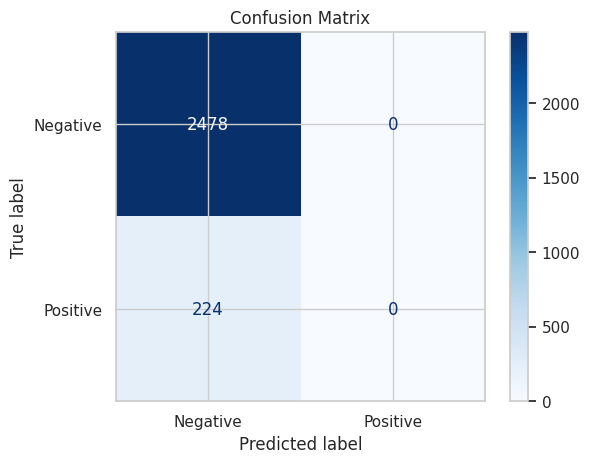

In [119]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/CNN_Transformer/cnn_transformer_inbalanced_cm')

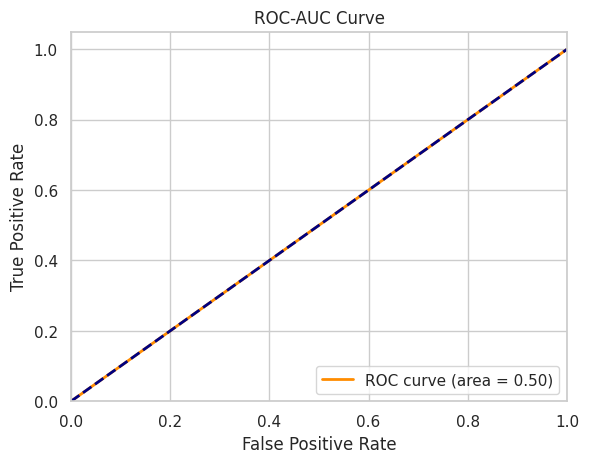

In [120]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/CNN_Transformer/cnn_transformer_inbalanced_roc_auc')

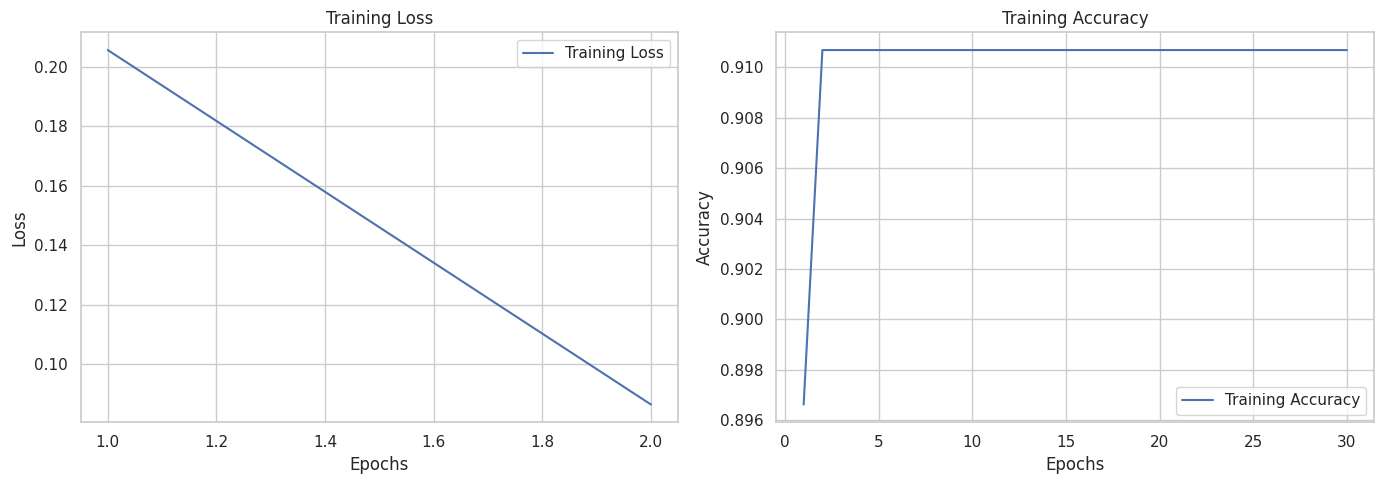

In [121]:
hf.plot_history(history, '1_pair/CNN_Transformer/cnn_transformer_inbalanced_history')

In [122]:
results_df1.loc[len(results_df1)] = ['1', 'CNN_Transformer', False, hf.f1(labels_1p_test, predictions), hf.mean_f1(labels_1p_test, predictions)]
results_df1

Tokenization            Model  Balanced  F1-score  Mean F1-score
0            1         Baseline     False  0.104478       0.528874
1            1         Baseline      True  0.188629       0.439160
2            1             LSTM     False  0.218978       0.588631
3            1             LSTM      True  0.156951       0.439764
4            1      Transformer     False  0.230216       0.594234
5            1      Transformer      True  0.208092       0.489689
6            1  CNN_Transformer     False  0.000000       0.478378

* Fit into balanced data

In [123]:
cnn_transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
cnn_transformer_1.compile(optimizer=tf.keras.optimizers.AdamW(),
                          loss="binary_focal_crossentropy",
                          metrics=['accuracy'])
history = cnn_transformer_1.fit(sequences_1p_train_balanced, labels_1p_train_balanced, epochs=30, batch_size=32)

Epoch 1/30
61/61 [==============================] - 10s 145ms/step - loss: nan - accuracy: 0.5000
Epoch 2/30
61/61 [==============================] - 9s 143ms/step - loss: nan - accuracy: 0.5000
Epoch 3/30
61/61 [==============================] - 9s 146ms/step - loss: nan - accuracy: 0.5000
Epoch 4/30
61/61 [==============================] - 9s 142ms/step - loss: nan - accuracy: 0.5000
Epoch 5/30
61/61 [==============================] - 9s 142ms/step - loss: nan - accuracy: 0.5000
Epoch 6/30
61/61 [==============================] - 9s 144ms/step - loss: nan - accuracy: 0.5000
Epoch 7/30
61/61 [==============================] - 9s 143ms/step - loss: nan - accuracy: 0.5000
Epoch 8/30
61/61 [==============================] - 9s 143ms/step - loss: nan - accuracy: 0.5000
Epoch 9/30
61/61 [==============================] - 9s 143ms/step - loss: nan - accuracy: 0.5000
Epoch 10/30
61/61 [==============================] - 9s 143ms/step - loss: nan - accuracy: 0.5000
Epoch 11/30
61/61 [=========

In [124]:
predictions = cnn_transformer_1.predict(sequences_1p_test)

85/85 [==============================] - 5s 53ms/step


In [125]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.917098445595855
Mean F1 Score:  0.4783783783783784
F1 Score:  0.0
Loss:  nan


In [126]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96      2478
    Positive       0.00      0.00      0.00       224

    accuracy                           0.92      2702
   macro avg       0.46      0.50      0.48      2702
weighted avg       0.84      0.92      0.88      2702



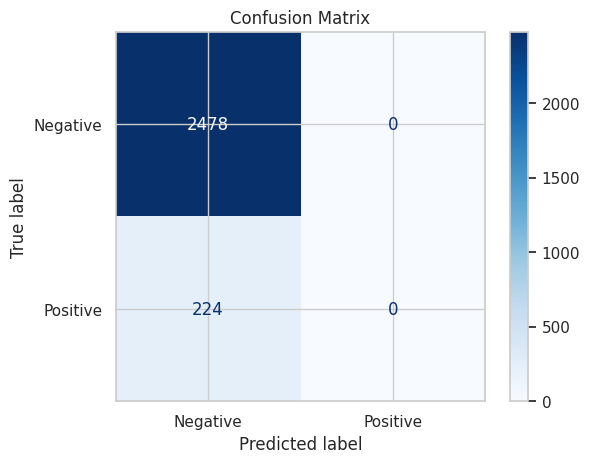

In [127]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/CNN_Transformer/cnn_transformer_balanced_cm')

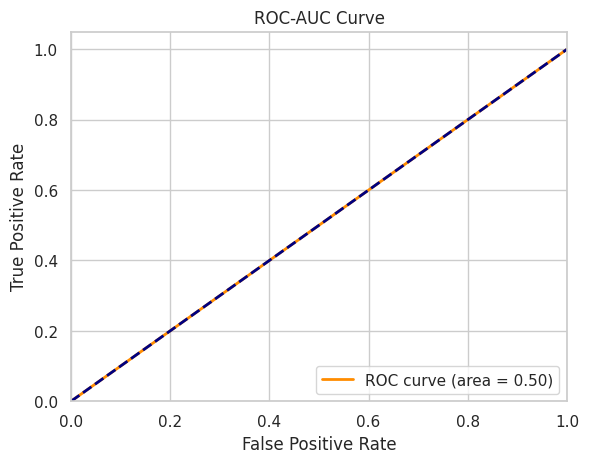

In [128]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/CNN_Transformer/cnn_transformer_balanced_roc_auc')

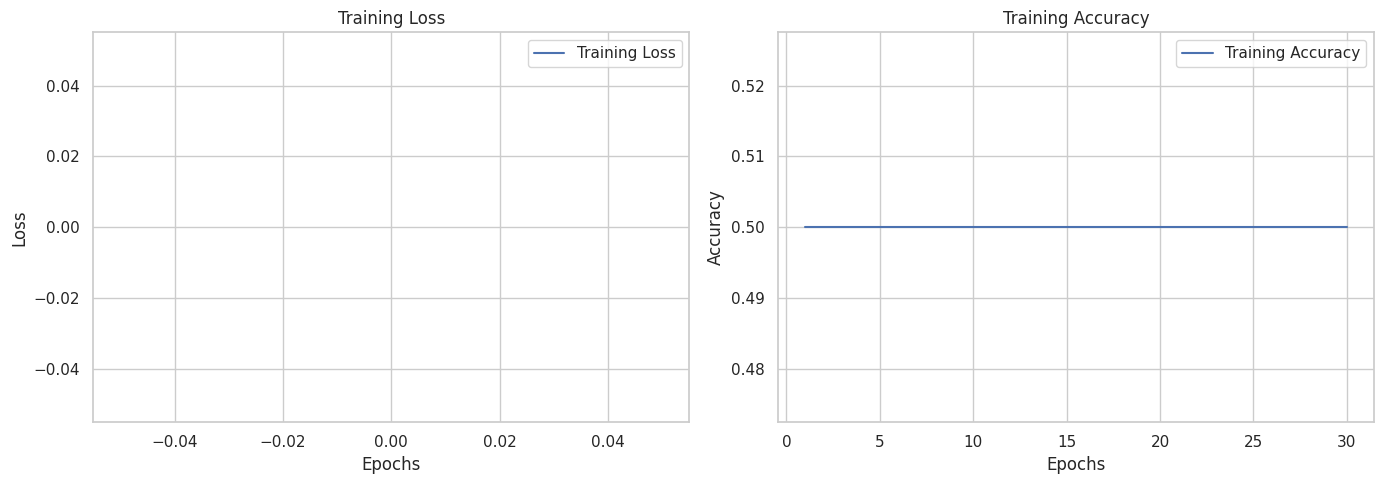

In [129]:
hf.plot_history(history, '1_pair/CNN_Transformer/cnn_transformer_balanced_history')

In [130]:
results_df1.loc[len(results_df1)] = ['1', 'CNN_Transformer', True, hf.f1(labels_1p_test, predictions), hf.mean_f1(labels_1p_test, predictions)]
results_df1

Tokenization            Model  Balanced  F1-score  Mean F1-score
0            1         Baseline     False  0.104478       0.528874
1            1         Baseline      True  0.188629       0.439160
2            1             LSTM     False  0.218978       0.588631
3            1             LSTM      True  0.156951       0.439764
4            1      Transformer     False  0.230216       0.594234
5            1      Transformer      True  0.208092       0.489689
6            1  CNN_Transformer     False  0.000000       0.478378
7            1  CNN_Transformer      True  0.000000       0.478378

### Results

In [131]:
results_df1

Tokenization            Model  Balanced  F1-score  Mean F1-score
0            1         Baseline     False  0.104478       0.528874
1            1         Baseline      True  0.188629       0.439160
2            1             LSTM     False  0.218978       0.588631
3            1             LSTM      True  0.156951       0.439764
4            1      Transformer     False  0.230216       0.594234
5            1      Transformer      True  0.208092       0.489689
6            1  CNN_Transformer     False  0.000000       0.478378
7            1  CNN_Transformer      True  0.000000       0.478378

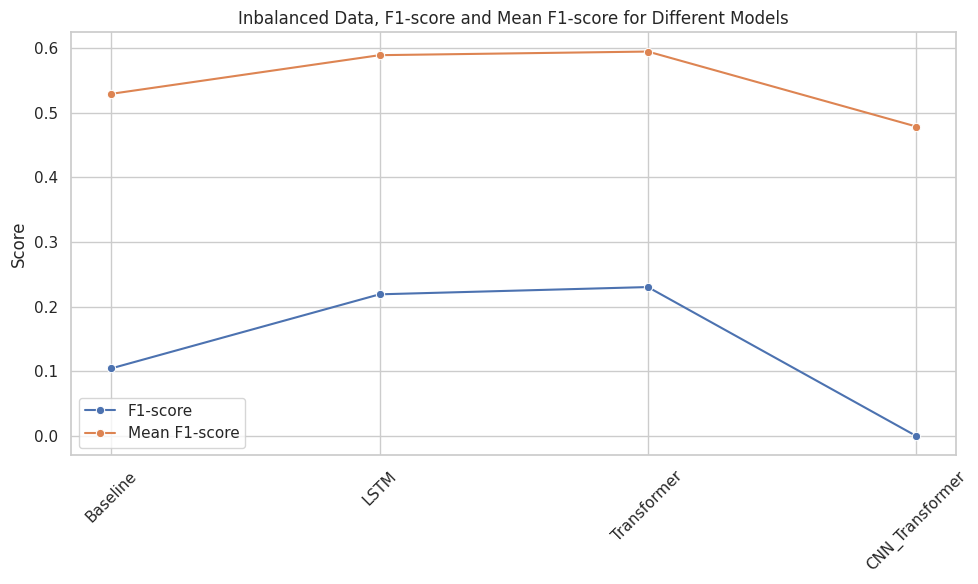

In [132]:
inbalanced_df = results_df1[results_df1['Balanced'] == False]

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=inbalanced_df, x='Model', y='F1-score', marker='o', label='F1-score')
sns.lineplot(data=inbalanced_df, x='Model', y='Mean F1-score', marker='o', label='Mean F1-score')

# Customize the plot with titles and labels
plt.title('Inbalanced Data, F1-score and Mean F1-score for Different Models')
plt.xlabel(None)
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig('Figures/Modeling/1_pair/Inbalanced_data_results.png')
plt.show()

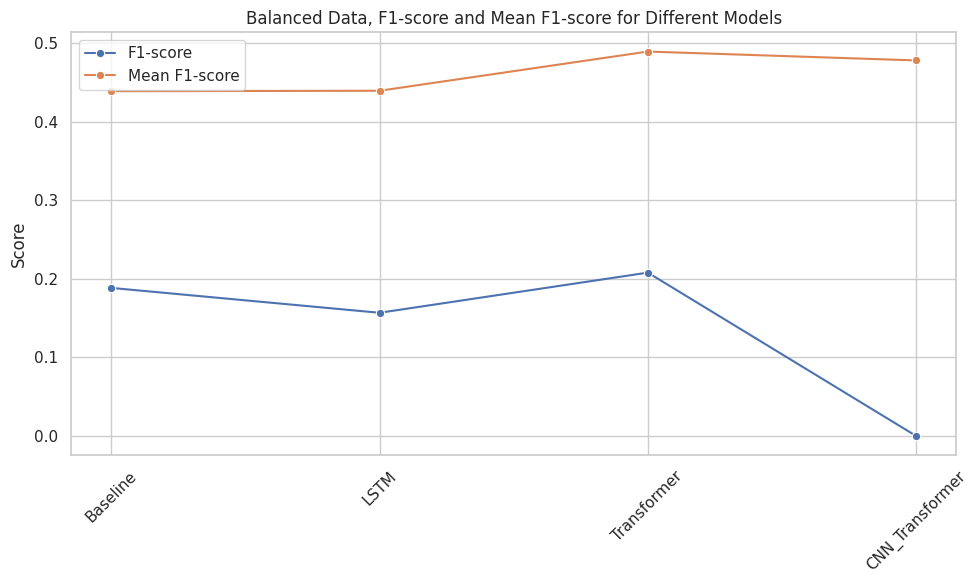

In [133]:
balanced_df = results_df1[results_df1['Balanced'] == True]

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=balanced_df, x='Model', y='F1-score', marker='o', label='F1-score')
sns.lineplot(data=balanced_df, x='Model', y='Mean F1-score', marker='o', label='Mean F1-score')

# Customize the plot with titles and labels
plt.title('Balanced Data, F1-score and Mean F1-score for Different Models')
plt.xlabel(None)
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig('Figures/Modeling/1_pair/Balanced_data_results.png')
plt.show()

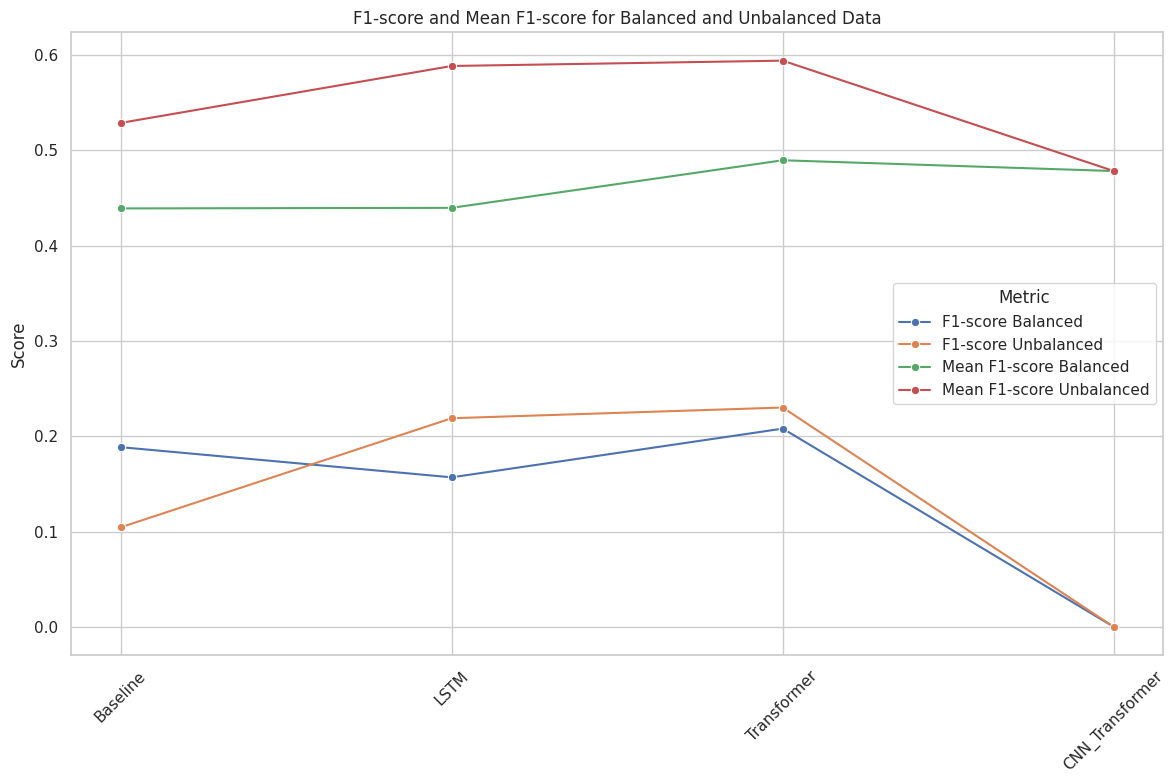

In [134]:
results_df1['F1-score_Balanced'] = results_df1.apply(lambda row: row['F1-score'] if row['Balanced'] else None, axis=1)
results_df1['F1-score_Unbalanced'] = results_df1.apply(lambda row: row['F1-score'] if not row['Balanced'] else None, axis=1)
results_df1['Mean_F1-score_Balanced'] = results_df1.apply(lambda row: row['Mean F1-score'] if row['Balanced'] else None, axis=1)
results_df1['Mean_F1-score_Unbalanced'] = results_df1.apply(lambda row: row['Mean F1-score'] if not row['Balanced'] else None, axis=1)

# Plot the data
plt.figure(figsize=(12, 8))

# Plot each line separately
sns.lineplot(data=results_df1, x='Model', y='F1-score_Balanced', marker='o', label='F1-score Balanced')
sns.lineplot(data=results_df1, x='Model', y='F1-score_Unbalanced', marker='o', label='F1-score Unbalanced')
sns.lineplot(data=results_df1, x='Model', y='Mean_F1-score_Balanced', marker='o', label='Mean F1-score Balanced')
sns.lineplot(data=results_df1, x='Model', y='Mean_F1-score_Unbalanced', marker='o', label='Mean F1-score Unbalanced')

# Customize the plot with titles and labels
plt.title('F1-score and Mean F1-score for Balanced and Unbalanced Data')
plt.xlabel(None)
plt.ylabel('Score')
plt.legend(title='Metric', loc='center right')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig('Figures/Modeling/1_pair/Results.png')
plt.show()

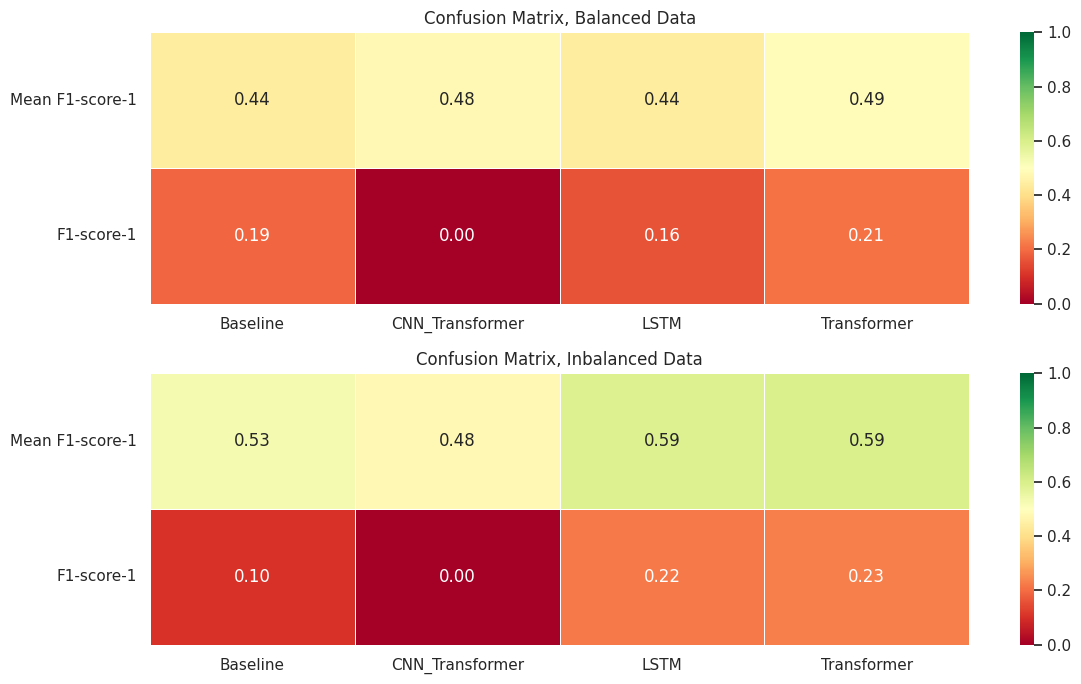

In [135]:
# Create confusion matrix for Balanced=True
conf_matrix_balanced_true = balanced_df.pivot(index='Model',
                                              columns='Tokenization',
                                              values=['Mean F1-score', 'F1-score']).T

# Create confusion matrix for Balanced=False
conf_matrix_balanced_false = inbalanced_df.pivot(index='Model',
                                                 columns='Tokenization',
                                                 values=['Mean F1-score', 'F1-score']).T

# Plot the confusion matrixes
fig, axs = plt.subplots(2, 1, figsize=(12, 7))

# Confusion matrix for Balanced=True
sns.heatmap(conf_matrix_balanced_true, annot=True, fmt=".2f", cmap="RdYlGn", cbar=True, linewidths=0.5, vmin=0, vmax=1, ax=axs[0])
axs[0].set_title('Confusion Matrix, Balanced Data')
axs[0].set_xlabel(None)
axs[0].set_ylabel(None)
axs[0].tick_params(axis='y', labelrotation=0)

# Confusion matrix for Balanced=False
sns.heatmap(conf_matrix_balanced_false, annot=True, fmt=".2f", cmap="RdYlGn", cbar=True, linewidths=0.5, vmin=0, vmax=1, ax=axs[1])
axs[1].set_title('Confusion Matrix, Inbalanced Data')
axs[1].set_xlabel(None)
axs[1].set_ylabel(None)
axs[1].tick_params(axis='y', labelrotation=0)

plt.tight_layout()
plt.savefig('Figures/Modeling/1_pair/Results_cm.png')
plt.show()

## Modeling (2 Aminos Tokenization)

In [136]:
results_df2 = pd.DataFrame(columns=['Tokenization', 'Model', 'Balanced', 'F1-score', 'Mean F1-score'])

In [137]:
sequences_2p_train.shape[1] == sequences_2p_train_balanced.shape[1]

True

In [138]:
sequence_len = sequences_2p_train.shape[1]
voc_size = len(tokenizer2.word_index)
embedding_dim = 500

voc_size

466

### Baseline

* Fit into inbalanced data

In [139]:
lr = LogisticRegression()
lr.fit(sequences_2p_train, labels_2p_train.values.ravel())

/home/konstantinosmpouros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [140]:
predictions = lr.predict(sequences_2p_test)
lr.score(sequences_2p_test, labels_2p_test)

0.9130273871206513

In [141]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      0.99      0.95      2478
    Positive       0.35      0.06      0.10       224

    accuracy                           0.91      2702
   macro avg       0.64      0.52      0.53      2702
weighted avg       0.87      0.91      0.88      2702



In [142]:
results_df2.loc[len(results_df2)] = ['2', 'Baseline', False, hf.f1(labels_2p_test, predictions), hf.mean_f1(labels_2p_test, predictions)]
results_df2

Tokenization     Model  Balanced  F1-score  Mean F1-score
0            2  Baseline     False  0.099617       0.526962

* Fit into balanced data

In [143]:
lr = LogisticRegression()
lr.fit(sequences_2p_train_balanced, labels_2p_train_balanced.values.ravel())

/home/konstantinosmpouros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [144]:
predictions = lr.predict(sequences_2p_test)
lr.score(sequences_2p_test, labels_2p_test)

0.5470022205773502

In [145]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.94      0.54      0.69      2478
    Positive       0.11      0.60      0.18       224

    accuracy                           0.55      2702
   macro avg       0.52      0.57      0.43      2702
weighted avg       0.87      0.55      0.64      2702



In [146]:
results_df2.loc[len(results_df2)] = ['2', 'Baseline', True, hf.f1(labels_2p_test, predictions), hf.mean_f1(labels_2p_test, predictions)]
results_df2

Tokenization     Model  Balanced  F1-score  Mean F1-score
0            2  Baseline     False  0.099617       0.526962
1            2  Baseline      True  0.180723       0.433840

### LSTM

* Model Initialisation

In [147]:
inputs = Input(shape=(sequence_len), name='Input')
embeddings = Embedding(input_dim=voc_size, output_dim=embedding_dim, input_length=sequence_len, name='Embeddings')(inputs)

lstms1 = LSTM(20, name='LSTM_layer_1', return_sequences=True)(embeddings)
x = Dropout(0.1)(lstms1)
lstms2 = LSTM(20, name='LSTM_layer_2', return_sequences=True)(x)
x = Dropout(0.1)(lstms1)
lstms3 = LSTM(20, name='LSTM_layer_3')(x)

dense1 = Dense(50, activation='relu', name='Dense_1')(lstms3)
dense2 = Dense(20, activation='relu', name='Dense_2')(dense1)

outputs = Dense(1, activation=tf.keras.activations.hard_sigmoid, name='Output')(dense2)

In [148]:
model_1 = Model(inputs=inputs, outputs=outputs)
model_1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 989)]             0         
                                                                 
 Embeddings (Embedding)      (None, 989, 500)          233000    
                                                                 
 LSTM_layer_1 (LSTM)         (None, 989, 20)           41680     
                                                                 
 dropout_3 (Dropout)         (None, 989, 20)           0         
                                                                 
 LSTM_layer_3 (LSTM)         (None, 20)                3280      
                                                                 
 Dense_1 (Dense)             (None, 50)                1050      
                                                                 
 Dense_2 (Dense)             (None, 20)                1020

In [149]:
model_1.compile(optimizer=tf.keras.optimizers.AdamW(), loss='binary_focal_crossentropy', metrics=['accuracy'])

* Fit into inbalanced data

In [150]:
history = model_1.fit(sequences_2p_train, labels_2p_train, epochs=30, batch_size=25)

Epoch 1/30
433/433 [==============================] - 47s 104ms/step - loss: 0.0826 - accuracy: 0.9099
Epoch 2/30
433/433 [==============================] - 43s 99ms/step - loss: 0.0790 - accuracy: 0.9121
Epoch 3/30
433/433 [==============================] - 39s 91ms/step - loss: 0.0775 - accuracy: 0.9145
Epoch 4/30
433/433 [==============================] - 41s 95ms/step - loss: 0.0760 - accuracy: 0.9161
Epoch 5/30
433/433 [==============================] - 43s 98ms/step - loss: 0.0748 - accuracy: 0.9157
Epoch 6/30
433/433 [==============================] - 43s 100ms/step - loss: 0.0739 - accuracy: 0.9174
Epoch 7/30
433/433 [==============================] - 38s 88ms/step - loss: 0.0723 - accuracy: 0.9199
Epoch 8/30
433/433 [==============================] - 46s 107ms/step - loss: 0.0712 - accuracy: 0.9204
Epoch 9/30
433/433 [==============================] - 49s 112ms/step - loss: 0.0699 - accuracy: 0.9211
Epoch 10/30
433/433 [==============================] - 43s 98ms/step - loss: 0

In [151]:
predictions = model_1.predict(sequences_2p_test)

85/85 [==============================] - 5s 55ms/step


In [152]:
predictions = hf.model_accuracy(labels_2p_test, predictions)

Accuracy:  0.9059955588452998
Mean F1 Score:  0.5756584235427379
F1 Score:  0.20125786163522014
Loss:  0.4863


In [153]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.93      0.97      0.95      2478
    Positive       0.34      0.14      0.20       224

    accuracy                           0.91      2702
   macro avg       0.63      0.56      0.58      2702
weighted avg       0.88      0.91      0.89      2702



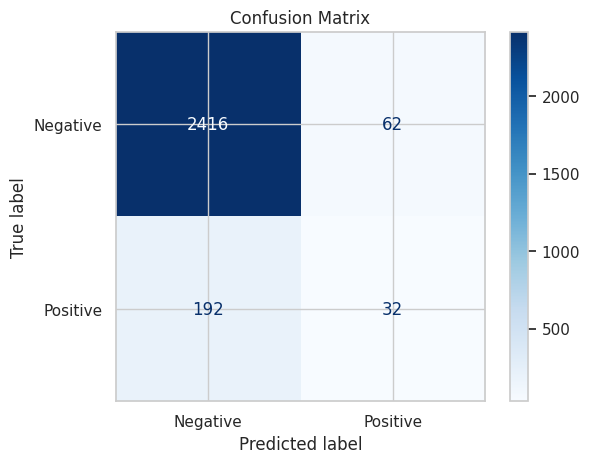

In [154]:
hf.conf_matrix(labels_2p_test, predictions, '2_pair/LSTM/lstm_inbalanced_cm')

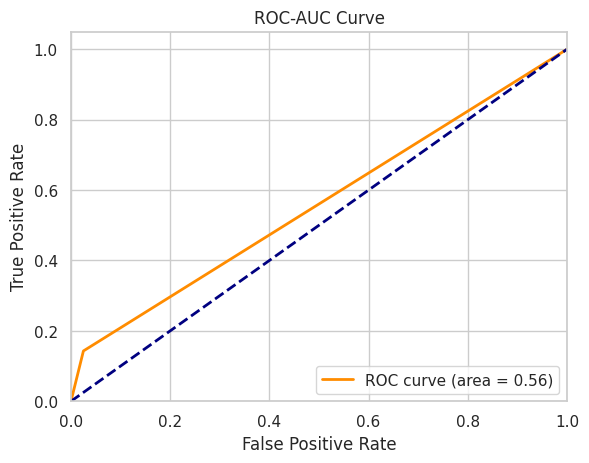

In [155]:
hf.roc_auc_curve(labels_2p_test, predictions, '2_pair/LSTM/lstm_inbalanced_roc_auc')

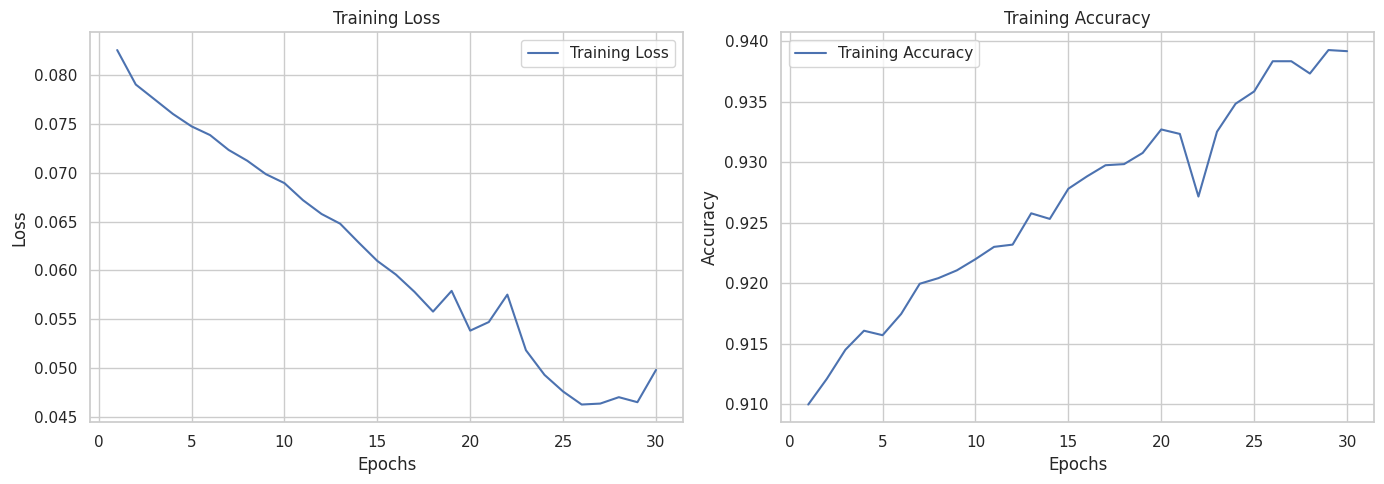

In [156]:
hf.plot_history(history, '2_pair/LSTM/lstm_inbalanced_history')

In [157]:
results_df2.loc[len(results_df2)] = ['2', 'LSTM', False, hf.f1(labels_2p_test, predictions), hf.mean_f1(labels_2p_test, predictions)]
results_df2

Tokenization     Model  Balanced  F1-score  Mean F1-score
0            2  Baseline     False  0.099617       0.526962
1            2  Baseline      True  0.180723       0.433840
2            2      LSTM     False  0.201258       0.575658

* Fit into balanced data

In [158]:
model_1 = Model(inputs=inputs, outputs=outputs)
model_1.compile(optimizer=tf.keras.optimizers.AdamW(), loss='binary_focal_crossentropy', metrics=['accuracy'])
history = model_1.fit(sequences_2p_train_balanced, labels_2p_train_balanced, epochs=30, batch_size=25)

Epoch 1/30
78/78 [==============================] - 13s 137ms/step - loss: 0.1037 - accuracy: 0.7793
Epoch 2/30
78/78 [==============================] - 8s 104ms/step - loss: 0.0820 - accuracy: 0.8399
Epoch 3/30
78/78 [==============================] - 7s 91ms/step - loss: 0.0699 - accuracy: 0.8684
Epoch 4/30
78/78 [==============================] - 8s 108ms/step - loss: 0.0672 - accuracy: 0.8725
Epoch 5/30
78/78 [==============================] - 8s 106ms/step - loss: 0.0625 - accuracy: 0.8850
Epoch 6/30
78/78 [==============================] - 8s 106ms/step - loss: 0.0573 - accuracy: 0.8943
Epoch 7/30
78/78 [==============================] - 8s 105ms/step - loss: 0.0658 - accuracy: 0.8922
Epoch 8/30
78/78 [==============================] - 7s 96ms/step - loss: 0.0687 - accuracy: 0.8741
Epoch 9/30
78/78 [==============================] - 7s 90ms/step - loss: 0.0625 - accuracy: 0.8891
Epoch 10/30
78/78 [==============================] - 8s 97ms/step - loss: 0.0555 - accuracy: 0.9026
Ep

In [159]:
predictions = model_1.predict(sequences_2p_test)

85/85 [==============================] - 5s 51ms/step


In [160]:
predictions = hf.model_accuracy(labels_2p_test, predictions)

Accuracy:  0.6095484826054774
Mean F1 Score:  0.4693067072910777
F1 Score:  0.1964965727341965
Loss:  1.115


In [161]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.94      0.61      0.74      2478
    Positive       0.12      0.58      0.20       224

    accuracy                           0.61      2702
   macro avg       0.53      0.59      0.47      2702
weighted avg       0.87      0.61      0.70      2702



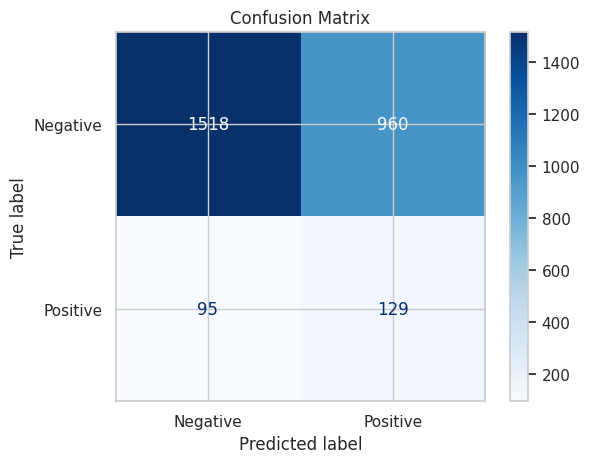

In [162]:
hf.conf_matrix(labels_2p_test, predictions, '2_pair/LSTM/lstm_balanced_cm')

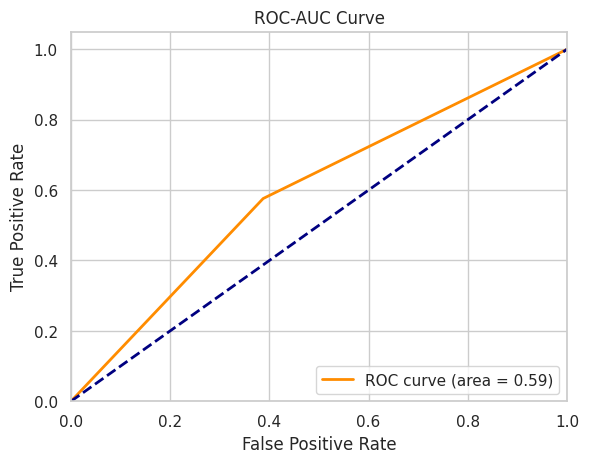

In [163]:
hf.roc_auc_curve(labels_2p_test, predictions, '2_pair/LSTM/lstm_balanced_roc_auc')

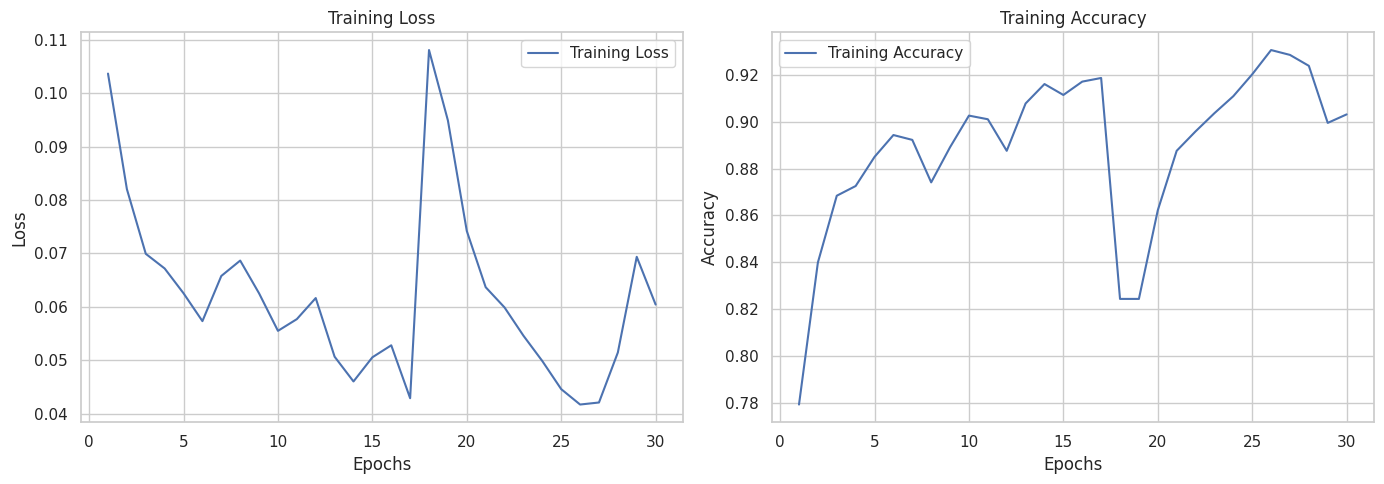

In [164]:
hf.plot_history(history, '2_pair/LSTM/lstm_balanced_history')

In [165]:
results_df2.loc[len(results_df2)] = ['2', 'LSTM', True, hf.f1(labels_2p_test, predictions), hf.mean_f1(labels_2p_test, predictions)]
results_df2

Tokenization     Model  Balanced  F1-score  Mean F1-score
0            2  Baseline     False  0.099617       0.526962
1            2  Baseline      True  0.180723       0.433840
2            2      LSTM     False  0.201258       0.575658
3            2      LSTM      True  0.196497       0.469307

### Transformer

* Model Initialisation

In [166]:
# input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')

# x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)

# x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)

# for i in range(4):
#     x = hf.transformer_block(x, 3, embedding_dim, i)

# x = GlobalAveragePooling1D(name='GAPooling1D')(x)
# x = Dropout(0.1, name='Dropout2')(x)

# outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [167]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')


x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)
x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)


attention = MultiHeadAttention(num_heads=10, key_dim=embedding_dim, name='Attention1')(x, x)
attention = Dropout(0.1, name='Dropout1')(attention)

attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm2')(x + dense)
x = GlobalAveragePooling1D(name='GAPooling1D')(x)
x = Dropout(0.1, name='Dropout2')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [168]:
transformer_2 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_2.compile(optimizer=tf.keras.optimizers.AdamW(), loss='binary_focal_crossentropy', metrics=["accuracy"])

In [169]:
transformer_2.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 989)]                0         []                            
                                                                                                  
 Embeddings (Embedding)      (None, 989, 500)             233000    ['Input[0][0]']               
                                                                                                  
 positional_encoding_2 (Pos  (None, 989, 500)             0         ['Embeddings[0][0]']          
 itionalEncoding)                                                                                 
                                                                                                  
 Attention1 (MultiHeadAtten  (None, 989, 500)             1001550   ['positional_encoding_2[

* Fit into inbalanced data

In [170]:
history = transformer_2.fit(sequences_2p_train, labels_2p_train, epochs=30, batch_size=32)

Epoch 1/30
338/338 [==============================] - 118s 342ms/step - loss: 0.2361 - accuracy: 0.8949
Epoch 2/30
338/338 [==============================] - 115s 340ms/step - loss: 0.0864 - accuracy: 0.9107
Epoch 3/30
338/338 [==============================] - 115s 340ms/step - loss: 0.0854 - accuracy: 0.9107
Epoch 4/30
338/338 [==============================] - 115s 340ms/step - loss: 0.0847 - accuracy: 0.9107
Epoch 5/30
338/338 [==============================] - 115s 340ms/step - loss: 0.0832 - accuracy: 0.9107
Epoch 6/30
338/338 [==============================] - 115s 340ms/step - loss: 0.0831 - accuracy: 0.9107
Epoch 7/30
338/338 [==============================] - 115s 340ms/step - loss: 0.0825 - accuracy: 0.9107
Epoch 8/30
338/338 [==============================] - 115s 340ms/step - loss: 0.0810 - accuracy: 0.9107
Epoch 9/30
338/338 [==============================] - 115s 340ms/step - loss: 0.0795 - accuracy: 0.9107
Epoch 10/30
338/338 [==============================] - 115s 340m

In [171]:
predictions = transformer_2.predict(sequences_2p_test)

85/85 [==============================] - 11s 127ms/step


In [172]:
predictions = hf.model_accuracy(labels_2p_test, predictions)

Accuracy:  0.9148778682457439
Mean F1 Score:  0.53191611155801
F1 Score:  0.10852713178294573
Loss:  0.3333


In [173]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      0.99      0.96      2478
    Positive       0.41      0.06      0.11       224

    accuracy                           0.91      2702
   macro avg       0.67      0.53      0.53      2702
weighted avg       0.88      0.91      0.89      2702



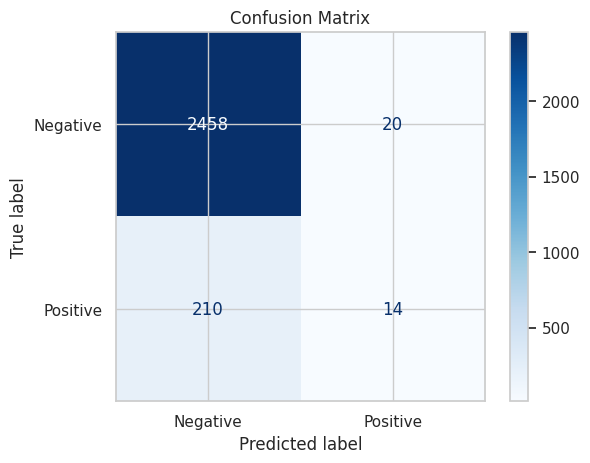

In [174]:
hf.conf_matrix(labels_2p_test, predictions, '2_pair/Transformer/transformer_inbalanced_cm')

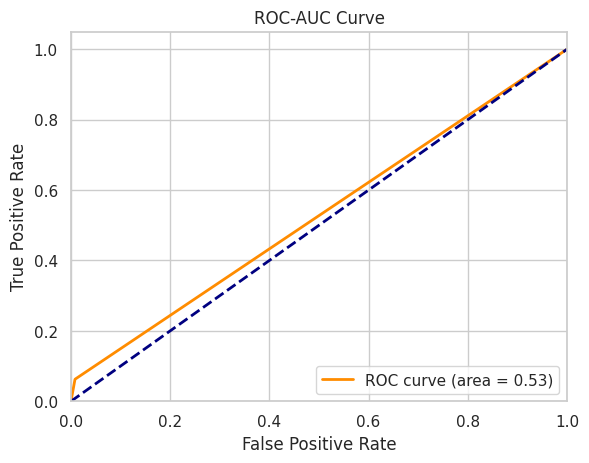

In [175]:
hf.roc_auc_curve(labels_2p_test, predictions, '2_pair/Transformer/transformer_inbalanced_roc_auc')

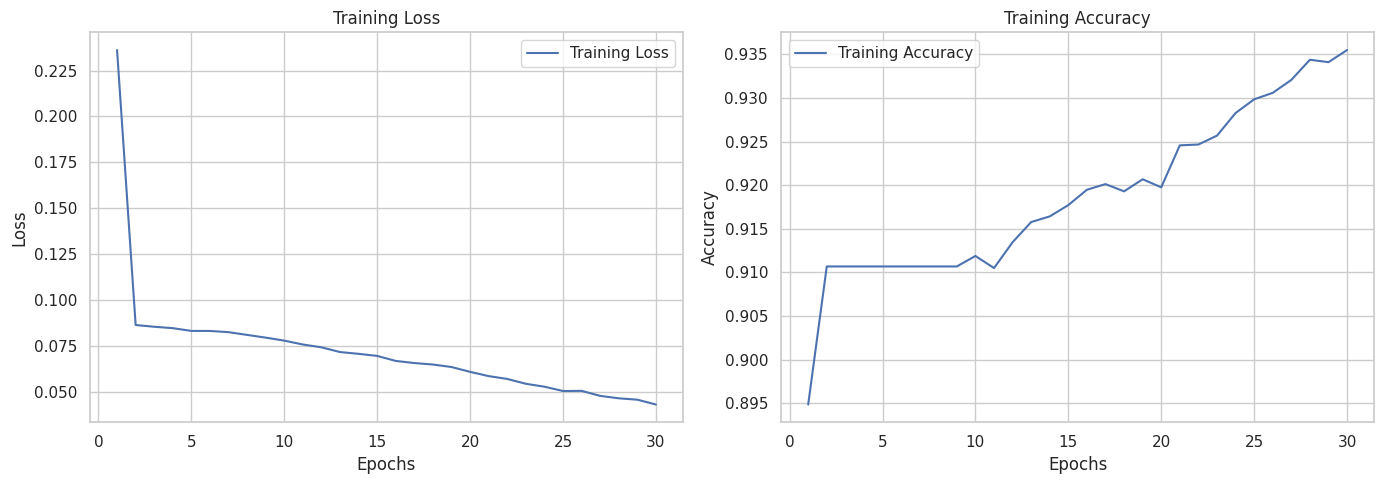

In [176]:
hf.plot_history(history, '2_pair/Transformer/transformer_inbalanced_history')

In [177]:
results_df2.loc[len(results_df2)] = ['2', 'Transformer', False, hf.f1(labels_2p_test, predictions), hf.mean_f1(labels_2p_test, predictions)]
results_df2

Tokenization        Model  Balanced  F1-score  Mean F1-score
0            2     Baseline     False  0.099617       0.526962
1            2     Baseline      True  0.180723       0.433840
2            2         LSTM     False  0.201258       0.575658
3            2         LSTM      True  0.196497       0.469307
4            2  Transformer     False  0.108527       0.531916

* Fit into balanced data

In [178]:
transformer_2 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_2.compile(optimizer=tf.keras.optimizers.AdamW(), loss='binary_focal_crossentropy', metrics=["accuracy"])
history = transformer_2.fit(sequences_2p_train_balanced, labels_2p_train_balanced, epochs=30, batch_size=32)

Epoch 1/30
61/61 [==============================] - 23s 348ms/step - loss: 0.0797 - accuracy: 0.8705
Epoch 2/30
61/61 [==============================] - 21s 342ms/step - loss: 0.0550 - accuracy: 0.9145
Epoch 3/30
61/61 [==============================] - 21s 346ms/step - loss: 0.0523 - accuracy: 0.9212
Epoch 4/30
61/61 [==============================] - 21s 345ms/step - loss: 0.0420 - accuracy: 0.9368
Epoch 5/30
61/61 [==============================] - 21s 343ms/step - loss: 0.0384 - accuracy: 0.9440
Epoch 6/30
61/61 [==============================] - 21s 344ms/step - loss: 0.0295 - accuracy: 0.9601
Epoch 7/30
61/61 [==============================] - 21s 347ms/step - loss: 0.0245 - accuracy: 0.9658
Epoch 8/30
61/61 [==============================] - 21s 347ms/step - loss: 0.0250 - accuracy: 0.9694
Epoch 9/30
61/61 [==============================] - 21s 349ms/step - loss: 0.0252 - accuracy: 0.9694
Epoch 10/30
61/61 [==============================] - 21s 342ms/step - loss: 0.0181 - accura

In [179]:
predictions = transformer_2.predict(sequences_2p_test)

85/85 [==============================] - 11s 131ms/step


In [180]:
predictions = hf.model_accuracy(labels_2p_test, predictions)

Accuracy:  0.6935603256846781
Mean F1 Score:  0.5127383541021996
F1 Score:  0.2159090909090909
Loss:  2.027


In [181]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.94      0.71      0.81      2478
    Positive       0.14      0.51      0.22       224

    accuracy                           0.69      2702
   macro avg       0.54      0.61      0.51      2702
weighted avg       0.87      0.69      0.76      2702



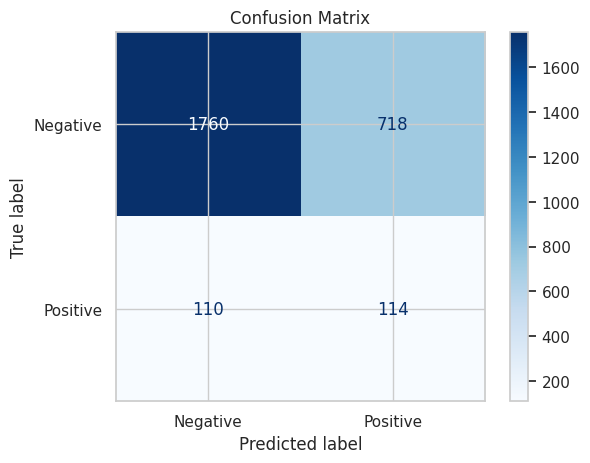

In [182]:
hf.conf_matrix(labels_2p_test, predictions, '2_pair/Transformer/transformer_balanced_cm')

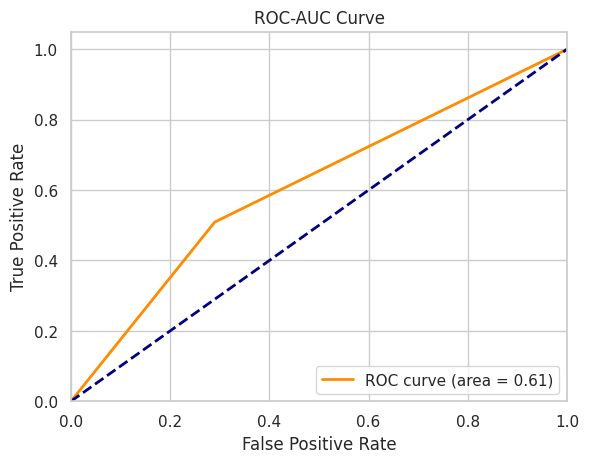

In [183]:
hf.roc_auc_curve(labels_2p_test, predictions, '2_pair/Transformer/transformer_balanced_roc_auc')

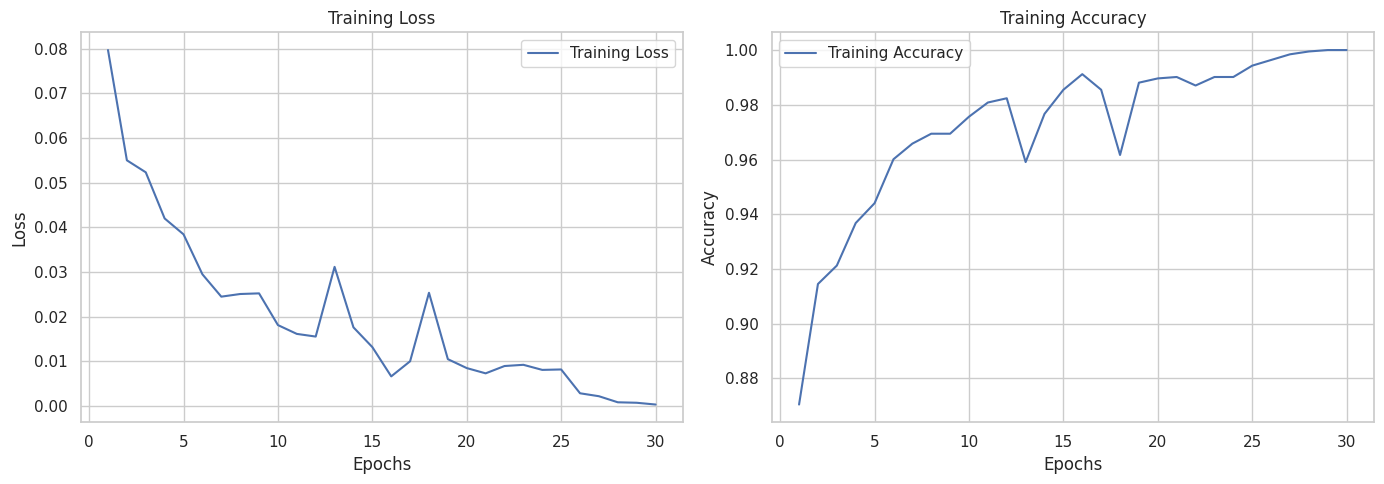

In [184]:
hf.plot_history(history, '2_pair/Transformer/transformer_balanced_history')

In [185]:
results_df2.loc[len(results_df2)] = ['2', 'Transformer', True, hf.f1(labels_2p_test, predictions), hf.mean_f1(labels_2p_test, predictions)]
results_df2

Tokenization        Model  Balanced  F1-score  Mean F1-score
0            2     Baseline     False  0.099617       0.526962
1            2     Baseline      True  0.180723       0.433840
2            2         LSTM     False  0.201258       0.575658
3            2         LSTM      True  0.196497       0.469307
4            2  Transformer     False  0.108527       0.531916
5            2  Transformer      True  0.215909       0.512738

### CNN Transformer

* Model Initialisation

In [186]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')
input_layer = Reshape((sequence_len, 1))(input_layer)

cnn1 = Conv1D(filters=embedding_dim, kernel_size=6, padding='same', activation='relu', name='Conv1D_1')(input_layer)
max_pool1 = MaxPooling1D(pool_size=2, name='MaxPooling1D_1')(cnn1)
# cnn2 = Conv1D(filters=embedding_dim, kernel_size=6, padding='same', activation='relu', name='Conv1D_2')(max_pool1)
# max_pool2 = MaxPooling1D(pool_size=2, name='MaxPooling1D_2')(cnn2)

x = PositionalEncoding(position=sequence_len // 2, d_model=embedding_dim)(max_pool1)


attention = MultiHeadAttention(num_heads=10, key_dim=embedding_dim, name='Attention_1')(x, x)
attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm_1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense_1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense_2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm_2')(x + dense)
x = GlobalAveragePooling1D(name='GAPooling1D')(x)
x = Dropout(0.1, name='Dropout')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [187]:
cnn_transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
cnn_transformer_1.compile(optimizer=tf.keras.optimizers.AdamW(),
                          loss="binary_focal_crossentropy",
                          metrics=['accuracy'])

In [188]:
cnn_transformer_1.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 989, 1)]             0         []                            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 989, 500)             3500      ['input_3[0][0]']             
                                                                                                  
 MaxPooling1D_1 (MaxPooling  (None, 494, 500)             0         ['Conv1D_1[1][0]']            
 1D)                                                                                              
                                                                                                  
 positional_encoding_3 (Pos  (None, 494, 500)             0         ['MaxPooling1D_1[1][0]'

* Fit into inbalanced data

In [189]:
history = cnn_transformer_1.fit(sequences_2p_train, labels_2p_train, epochs=30, batch_size=32)

Epoch 1/30
338/338 [==============================] - 53s 150ms/step - loss: 0.1631 - accuracy: 0.8978
Epoch 2/30
338/338 [==============================] - 50s 149ms/step - loss: 0.0874 - accuracy: 0.9106
Epoch 3/30
338/338 [==============================] - 51s 151ms/step - loss: 0.0854 - accuracy: 0.9107
Epoch 4/30
338/338 [==============================] - 50s 147ms/step - loss: 0.0838 - accuracy: 0.9107
Epoch 5/30
338/338 [==============================] - 50s 149ms/step - loss: 0.0832 - accuracy: 0.9105
Epoch 6/30
338/338 [==============================] - 50s 148ms/step - loss: 0.0827 - accuracy: 0.9107
Epoch 7/30
338/338 [==============================] - 50s 148ms/step - loss: nan - accuracy: 0.9107
Epoch 8/30
338/338 [==============================] - 49s 146ms/step - loss: nan - accuracy: 0.9107
Epoch 9/30
338/338 [==============================] - 49s 144ms/step - loss: nan - accuracy: 0.9107
Epoch 10/30
338/338 [==============================] - 49s 145ms/step - loss: nan 

In [190]:
predictions = cnn_transformer_1.predict(sequences_2p_test)

85/85 [==============================] - 5s 53ms/step


In [191]:
predictions = hf.model_accuracy(labels_2p_test, predictions)

Accuracy:  0.917098445595855
Mean F1 Score:  0.4783783783783784
F1 Score:  0.0
Loss:  nan


In [192]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96      2478
    Positive       0.00      0.00      0.00       224

    accuracy                           0.92      2702
   macro avg       0.46      0.50      0.48      2702
weighted avg       0.84      0.92      0.88      2702



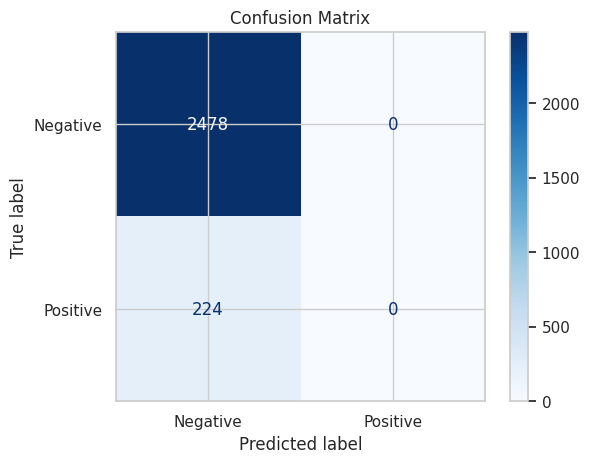

In [193]:
hf.conf_matrix(labels_2p_test, predictions, '2_pair/CNN_Transformer/cnn_transformer_inbalanced_cm')

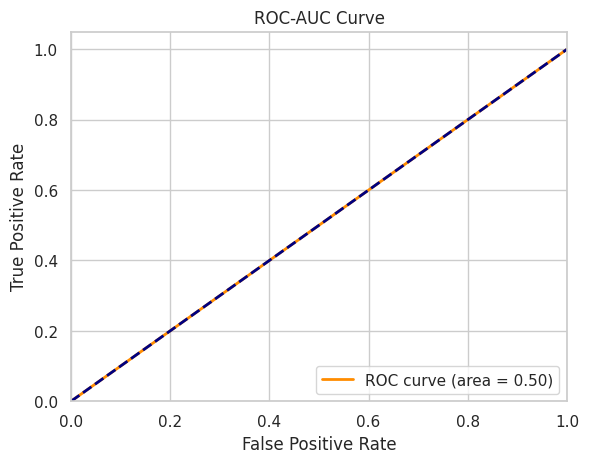

In [194]:
hf.roc_auc_curve(labels_2p_test, predictions, '2_pair/CNN_Transformer/cnn_transformer_inbalanced_roc_auc')

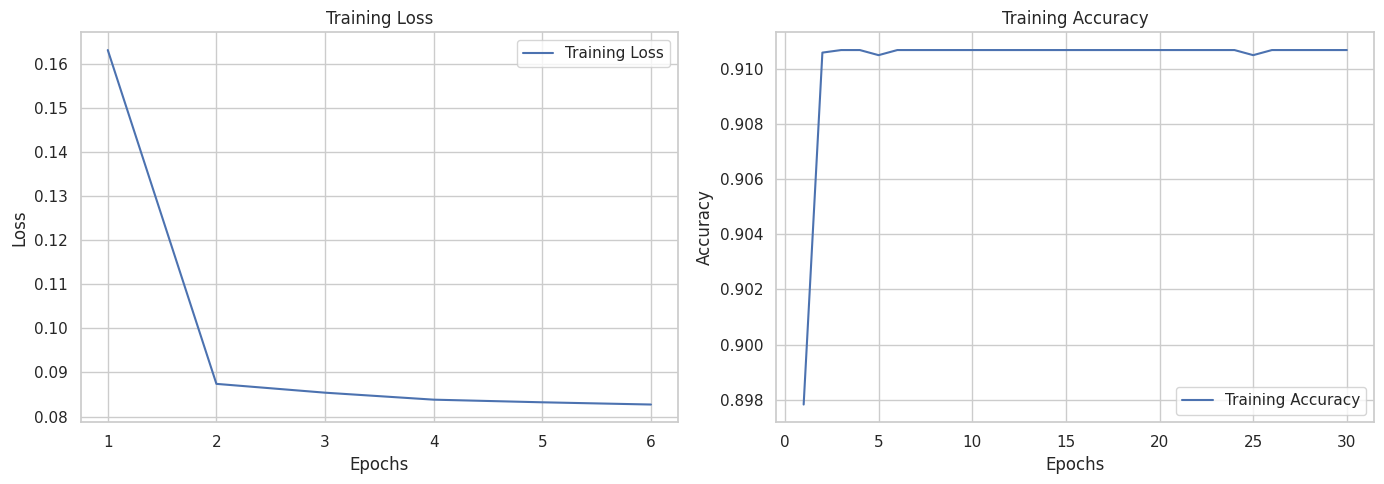

In [195]:
hf.plot_history(history, '2_pair/CNN_Transformer/cnn_transformer_inbalanced_history')

In [196]:
results_df2.loc[len(results_df2)] = ['2', 'CNN_Transformer', False, hf.f1(labels_2p_test, predictions), hf.mean_f1(labels_2p_test, predictions)]
results_df2

Tokenization            Model  Balanced  F1-score  Mean F1-score
0            2         Baseline     False  0.099617       0.526962
1            2         Baseline      True  0.180723       0.433840
2            2             LSTM     False  0.201258       0.575658
3            2             LSTM      True  0.196497       0.469307
4            2      Transformer     False  0.108527       0.531916
5            2      Transformer      True  0.215909       0.512738
6            2  CNN_Transformer     False  0.000000       0.478378

* Fit into balanced data

In [197]:
cnn_transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
cnn_transformer_1.compile(optimizer=tf.keras.optimizers.AdamW(),
                          loss="binary_focal_crossentropy",
                          metrics=['accuracy'])
history = cnn_transformer_1.fit(sequences_2p_train_balanced, labels_2p_train_balanced, epochs=30, batch_size=32)

Epoch 1/30
61/61 [==============================] - 11s 152ms/step - loss: nan - accuracy: 0.5290
Epoch 2/30
61/61 [==============================] - 8s 139ms/step - loss: nan - accuracy: 0.4741
Epoch 3/30
61/61 [==============================] - 8s 139ms/step - loss: nan - accuracy: 0.4829
Epoch 4/30
61/61 [==============================] - 8s 139ms/step - loss: nan - accuracy: 0.4850
Epoch 5/30
61/61 [==============================] - 8s 138ms/step - loss: nan - accuracy: 0.5021
Epoch 6/30
61/61 [==============================] - 8s 139ms/step - loss: nan - accuracy: 0.4917
Epoch 7/30
61/61 [==============================] - 9s 140ms/step - loss: nan - accuracy: 0.5000
Epoch 8/30
61/61 [==============================] - 8s 139ms/step - loss: nan - accuracy: 0.5000
Epoch 9/30
61/61 [==============================] - 8s 139ms/step - loss: nan - accuracy: 0.5000
Epoch 10/30
61/61 [==============================] - 8s 139ms/step - loss: nan - accuracy: 0.5000
Epoch 11/30
61/61 [=========

In [198]:
predictions = cnn_transformer_1.predict(sequences_2p_test)

85/85 [==============================] - 5s 53ms/step


In [199]:
predictions = hf.model_accuracy(labels_2p_test, predictions)

Accuracy:  0.8138415988156921
Mean F1 Score:  0.5359073498825175
F1 Score:  0.176759410801964
Loss:  nan


In [200]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.93      0.87      0.90      2478
    Positive       0.14      0.24      0.18       224

    accuracy                           0.81      2702
   macro avg       0.53      0.55      0.54      2702
weighted avg       0.86      0.81      0.84      2702



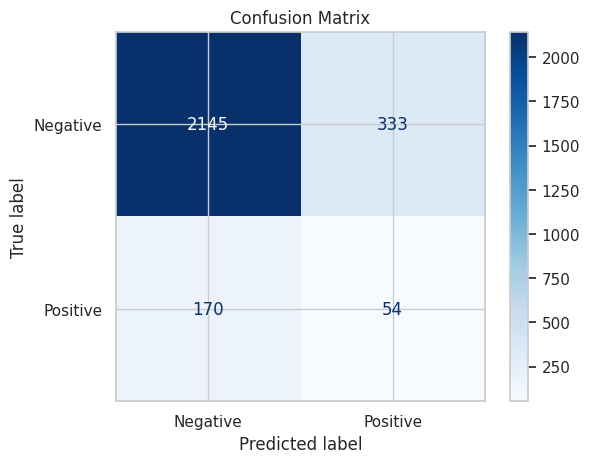

In [201]:
hf.conf_matrix(labels_2p_test, predictions, '2_pair/CNN_Transformer/cnn_transformer_balanced_cm')

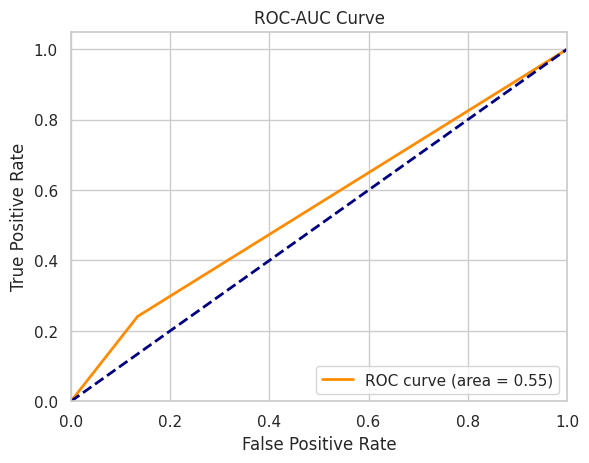

In [202]:
hf.roc_auc_curve(labels_2p_test, predictions, '2_pair/CNN_Transformer/cnn_transformer_balanced_roc_auc')

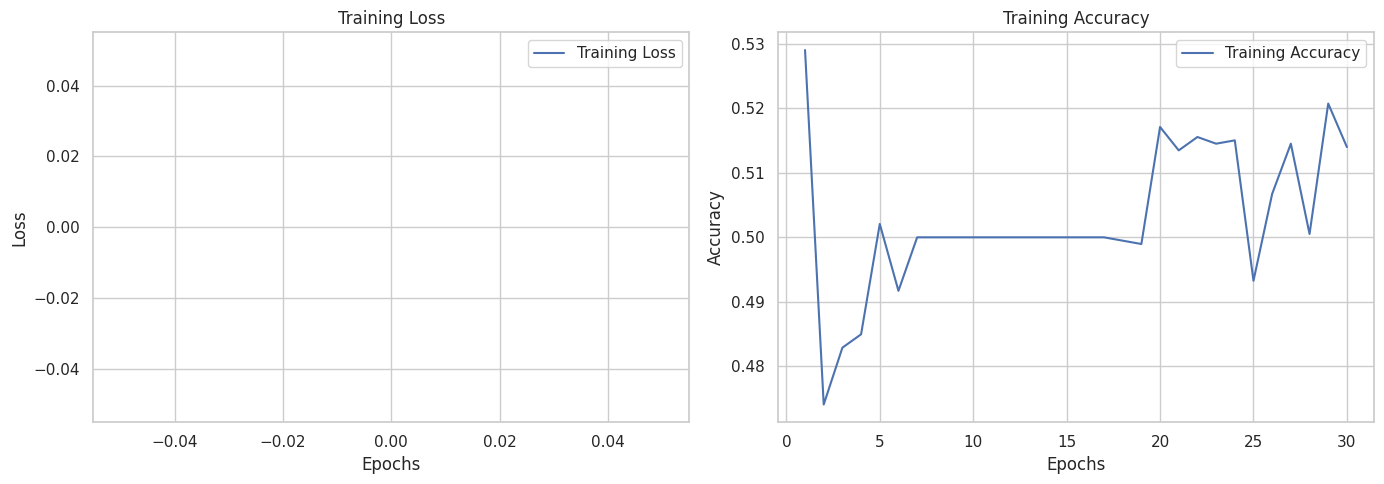

In [203]:
hf.plot_history(history, '2_pair/CNN_Transformer/cnn_transformer_balanced_history')

In [204]:
results_df2.loc[len(results_df2)] = ['2', 'CNN_Transformer', True, hf.f1(labels_2p_test, predictions), hf.mean_f1(labels_2p_test, predictions)]
results_df2

Tokenization            Model  Balanced  F1-score  Mean F1-score
0            2         Baseline     False  0.099617       0.526962
1            2         Baseline      True  0.180723       0.433840
2            2             LSTM     False  0.201258       0.575658
3            2             LSTM      True  0.196497       0.469307
4            2      Transformer     False  0.108527       0.531916
5            2      Transformer      True  0.215909       0.512738
6            2  CNN_Transformer     False  0.000000       0.478378
7            2  CNN_Transformer      True  0.176759       0.535907

### Results

In [205]:
results_df2

Tokenization            Model  Balanced  F1-score  Mean F1-score
0            2         Baseline     False  0.099617       0.526962
1            2         Baseline      True  0.180723       0.433840
2            2             LSTM     False  0.201258       0.575658
3            2             LSTM      True  0.196497       0.469307
4            2      Transformer     False  0.108527       0.531916
5            2      Transformer      True  0.215909       0.512738
6            2  CNN_Transformer     False  0.000000       0.478378
7            2  CNN_Transformer      True  0.176759       0.535907

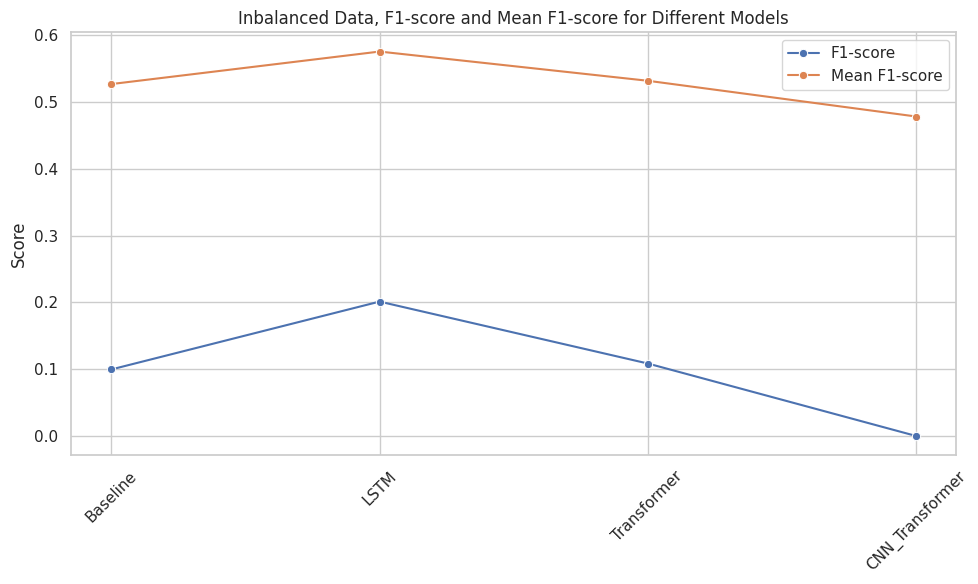

In [206]:
inbalanced_df = results_df2[results_df2['Balanced'] == False]

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=inbalanced_df, x='Model', y='F1-score', marker='o', label='F1-score')
sns.lineplot(data=inbalanced_df, x='Model', y='Mean F1-score', marker='o', label='Mean F1-score')

# Customize the plot with titles and labels
plt.title('Inbalanced Data, F1-score and Mean F1-score for Different Models')
plt.xlabel(None)
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig('Figures/Modeling/2_pair/Inbalanced_data_results.png')
plt.show()

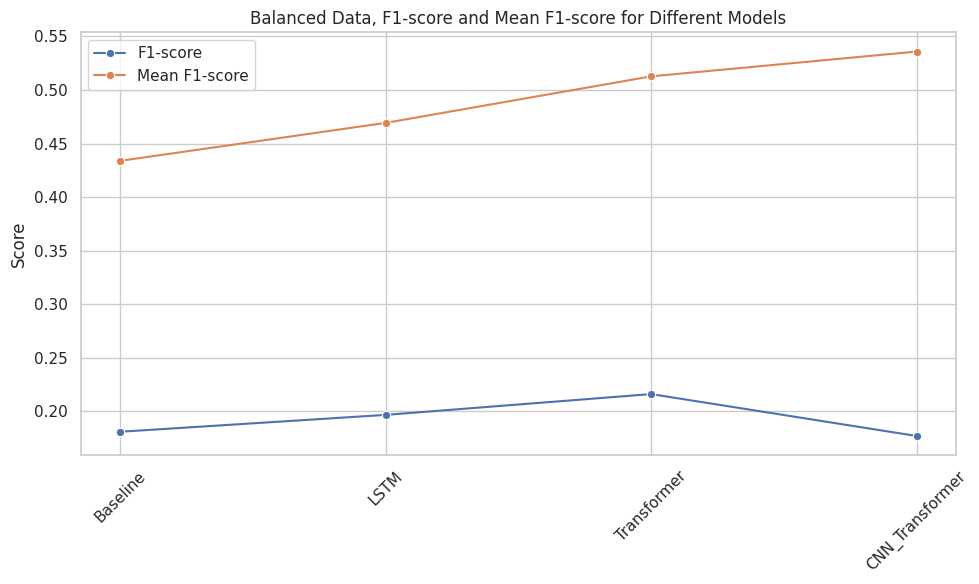

In [207]:
balanced_df = results_df2[results_df2['Balanced'] == True]

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=balanced_df, x='Model', y='F1-score', marker='o', label='F1-score')
sns.lineplot(data=balanced_df, x='Model', y='Mean F1-score', marker='o', label='Mean F1-score')

# Customize the plot with titles and labels
plt.title('Balanced Data, F1-score and Mean F1-score for Different Models')
plt.xlabel(None)
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig('Figures/Modeling/2_pair/Balanced_data_results.png')
plt.show()

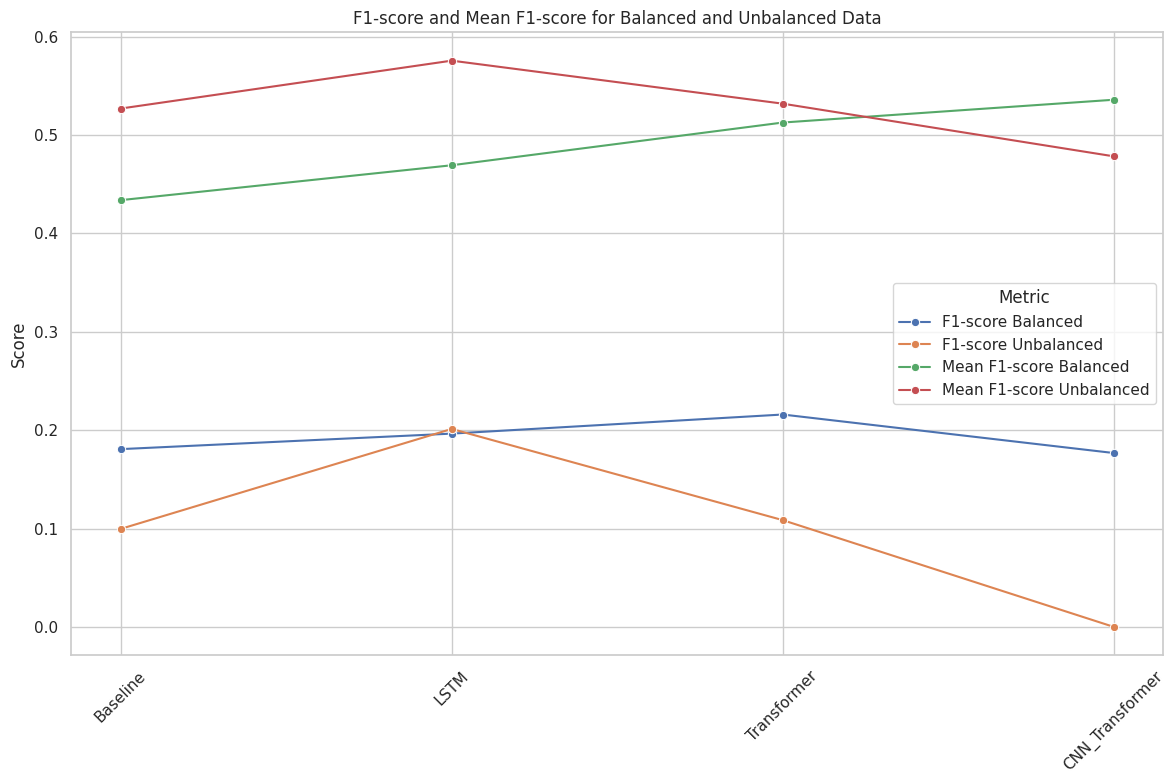

In [208]:
results_df2['F1-score_Balanced'] = results_df2.apply(lambda row: row['F1-score'] if row['Balanced'] else None, axis=1)
results_df2['F1-score_Unbalanced'] = results_df2.apply(lambda row: row['F1-score'] if not row['Balanced'] else None, axis=1)
results_df2['Mean_F1-score_Balanced'] = results_df2.apply(lambda row: row['Mean F1-score'] if row['Balanced'] else None, axis=1)
results_df2['Mean_F1-score_Unbalanced'] = results_df2.apply(lambda row: row['Mean F1-score'] if not row['Balanced'] else None, axis=1)

# Plot the data
plt.figure(figsize=(12, 8))

# Plot each line separately
sns.lineplot(data=results_df2, x='Model', y='F1-score_Balanced', marker='o', label='F1-score Balanced')
sns.lineplot(data=results_df2, x='Model', y='F1-score_Unbalanced', marker='o', label='F1-score Unbalanced')
sns.lineplot(data=results_df2, x='Model', y='Mean_F1-score_Balanced', marker='o', label='Mean F1-score Balanced')
sns.lineplot(data=results_df2, x='Model', y='Mean_F1-score_Unbalanced', marker='o', label='Mean F1-score Unbalanced')

# Customize the plot with titles and labels
plt.title('F1-score and Mean F1-score for Balanced and Unbalanced Data')
plt.xlabel(None)
plt.ylabel('Score')
plt.legend(title='Metric', loc='center right')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig('Figures/Modeling/2_pair/Results.png')
plt.show()

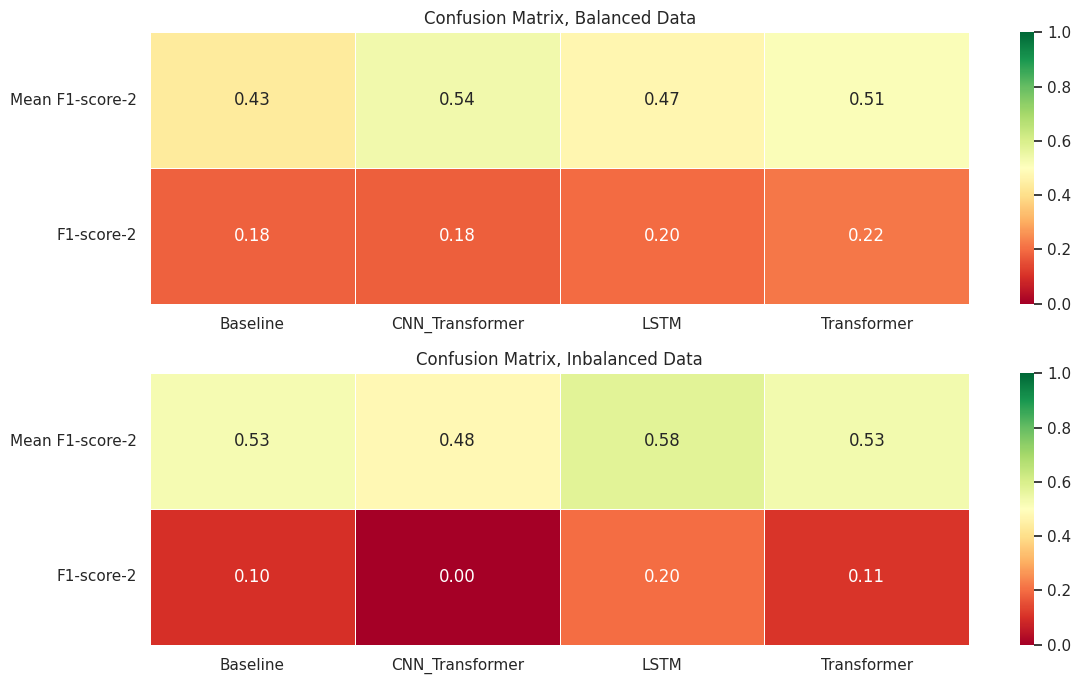

In [209]:
# Create confusion matrix for Balanced=True
conf_matrix_balanced_true = balanced_df.pivot(index='Model',
                                              columns='Tokenization',
                                              values=['Mean F1-score', 'F1-score']).T

# Create confusion matrix for Balanced=False
conf_matrix_balanced_false = inbalanced_df.pivot(index='Model',
                                                 columns='Tokenization',
                                                 values=['Mean F1-score', 'F1-score']).T

# Plot the confusion matrixes
fig, axs = plt.subplots(2, 1, figsize=(12, 7))

# Confusion matrix for Balanced=True
sns.heatmap(conf_matrix_balanced_true, annot=True, fmt=".2f", cmap="RdYlGn", cbar=True, linewidths=0.5, vmin=0, vmax=1, ax=axs[0])
axs[0].set_title('Confusion Matrix, Balanced Data')
axs[0].set_xlabel(None)
axs[0].set_ylabel(None)
axs[0].tick_params(axis='y', labelrotation=0)

# Confusion matrix for Balanced=False
sns.heatmap(conf_matrix_balanced_false, annot=True, fmt=".2f", cmap="RdYlGn", cbar=True, linewidths=0.5, vmin=0, vmax=1, ax=axs[1])
axs[1].set_title('Confusion Matrix, Inbalanced Data')
axs[1].set_xlabel(None)
axs[1].set_ylabel(None)
axs[1].tick_params(axis='y', labelrotation=0)

plt.tight_layout()
plt.savefig('Figures/Modeling/2_pair/Results_cm.png')
plt.show()

## Modeling (3 Aminos Tokenization)

In [210]:
results_df3 = pd.DataFrame(columns=['Tokenization', 'Model', 'Balanced', 'F1-score', 'Mean F1-score'])

In [211]:
sequences_3p_train.shape[1] == sequences_3p_train_balanced.shape[1]

True

In [212]:
sequence_len = sequences_3p_train.shape[1]
voc_size = len(tokenizer3.word_index)
embedding_dim = 500

voc_size

8476

### Baseline

* Fit into inbalanced data

In [213]:
lr = LogisticRegression()
lr.fit(sequences_3p_train, labels_3p_train.values.ravel())

/home/konstantinosmpouros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [214]:
predictions = lr.predict(sequences_3p_test)
lr.score(sequences_3p_test, labels_3p_test)

0.9119170984455959

In [215]:
hf.class_report(labels_3p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      0.99      0.95      2478
    Positive       0.15      0.01      0.02       224

    accuracy                           0.91      2702
   macro avg       0.53      0.50      0.49      2702
weighted avg       0.85      0.91      0.88      2702



In [216]:
results_df3.loc[len(results_df3)] = ['3', 'Baseline', False, hf.f1(labels_3p_test, predictions), hf.mean_f1(labels_3p_test, predictions)]
results_df3

Tokenization     Model  Balanced  F1-score  Mean F1-score
0            3  Baseline     False   0.02459       0.489233

* Fit into balanced data

In [217]:
lr = LogisticRegression()
lr.fit(sequences_3p_train_balanced, labels_3p_train_balanced.values.ravel())

/home/konstantinosmpouros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [218]:
predictions = lr.predict(sequences_3p_test)
lr.score(sequences_3p_test, labels_3p_test)

0.5421909696521096

In [219]:
hf.class_report(labels_3p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.93      0.54      0.68      2478
    Positive       0.10      0.58      0.17       224

    accuracy                           0.54      2702
   macro avg       0.52      0.56      0.43      2702
weighted avg       0.86      0.54      0.64      2702



In [220]:
results_df3.loc[len(results_df3)] = ['3', 'Baseline', True, hf.f1(labels_3p_test, predictions), hf.mean_f1(labels_3p_test, predictions)]
results_df3

Tokenization     Model  Balanced  F1-score  Mean F1-score
0            3  Baseline     False  0.024590       0.489233
1            3  Baseline      True  0.172575       0.428063

### LSTM

* Model Initialisation

In [221]:
inputs = Input(shape=(sequence_len), name='Input')
embeddings = Embedding(input_dim=voc_size, output_dim=embedding_dim, input_length=sequence_len, name='Embeddings')(inputs)

lstms1 = LSTM(20, name='LSTM_layer_1', return_sequences=True)(embeddings)
x = Dropout(0.1)(lstms1)
lstms2 = LSTM(20, name='LSTM_layer_2', return_sequences=True)(x)
x = Dropout(0.1)(lstms1)
lstms3 = LSTM(20, name='LSTM_layer_3')(x)

dense1 = Dense(10, activation='relu', name='Dense_1')(lstms3)
dense2 = Dense(5, activation='relu', name='Dense_2')(dense1)

outputs = Dense(1, activation=tf.keras.activations.hard_sigmoid, name='Output')(dense2)

In [222]:
model_1 = Model(inputs=inputs, outputs=outputs)
model_1.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 333)]             0         
                                                                 
 Embeddings (Embedding)      (None, 333, 500)          4238000   
                                                                 
 LSTM_layer_1 (LSTM)         (None, 333, 20)           41680     
                                                                 
 dropout_5 (Dropout)         (None, 333, 20)           0         
                                                                 
 LSTM_layer_3 (LSTM)         (None, 20)                3280      
                                                                 
 Dense_1 (Dense)             (None, 10)                210       
                                                                 
 Dense_2 (Dense)             (None, 5)                 55 

In [223]:
model_1.compile(optimizer=tf.keras.optimizers.AdamW(), loss='binary_focal_crossentropy', metrics=['accuracy'])

* Fit into inbalanced data

In [224]:
history = model_1.fit(sequences_3p_train, labels_3p_train, epochs=30, batch_size=25)

Epoch 1/30
433/433 [==============================] - 50s 112ms/step - loss: 0.0856 - accuracy: 0.9089
Epoch 2/30
433/433 [==============================] - 37s 85ms/step - loss: 0.0820 - accuracy: 0.9112
Epoch 3/30
433/433 [==============================] - 30s 69ms/step - loss: 0.0820 - accuracy: 0.9113
Epoch 4/30
433/433 [==============================] - 27s 62ms/step - loss: 0.0815 - accuracy: 0.9116
Epoch 5/30
433/433 [==============================] - 24s 57ms/step - loss: 0.0814 - accuracy: 0.9117
Epoch 6/30
433/433 [==============================] - 23s 54ms/step - loss: 0.0816 - accuracy: 0.9120
Epoch 7/30
433/433 [==============================] - 23s 54ms/step - loss: 0.0812 - accuracy: 0.9121
Epoch 8/30
433/433 [==============================] - 23s 53ms/step - loss: 0.0835 - accuracy: 0.9078
Epoch 9/30
433/433 [==============================] - 22s 50ms/step - loss: 0.0822 - accuracy: 0.9107
Epoch 10/30
433/433 [==============================] - 22s 50ms/step - loss: 0.08

In [225]:
predictions = model_1.predict(sequences_3p_test)

85/85 [==============================] - 2s 23ms/step


In [226]:
predictions = hf.model_accuracy(labels_3p_test, predictions)

Accuracy:  0.917098445595855
Mean F1 Score:  0.4783783783783784
F1 Score:  0.0
Loss:  0.4333


In [227]:
hf.class_report(labels_3p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96      2478
    Positive       0.00      0.00      0.00       224

    accuracy                           0.92      2702
   macro avg       0.46      0.50      0.48      2702
weighted avg       0.84      0.92      0.88      2702



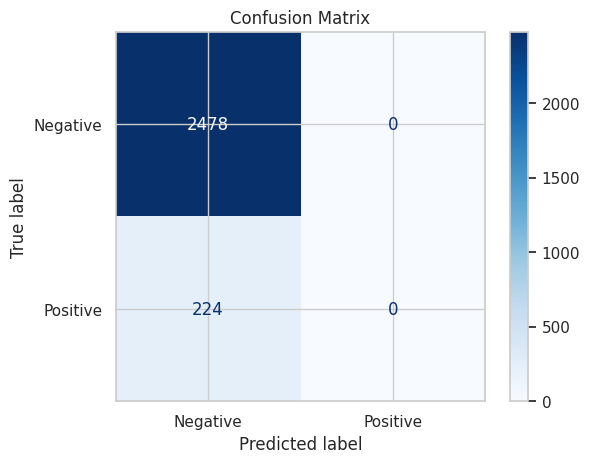

In [228]:
hf.conf_matrix(labels_3p_test, predictions, '3_pair/LSTM/lstm_inbalanced_cm')

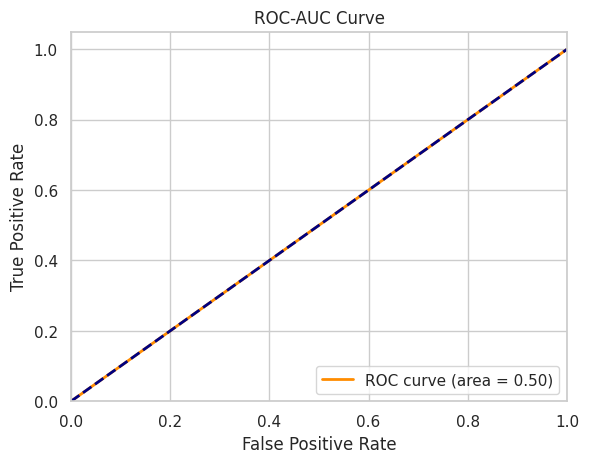

In [229]:
hf.roc_auc_curve(labels_3p_test, predictions, '3_pair/LSTM/lstm_inbalanced_roc_auc')

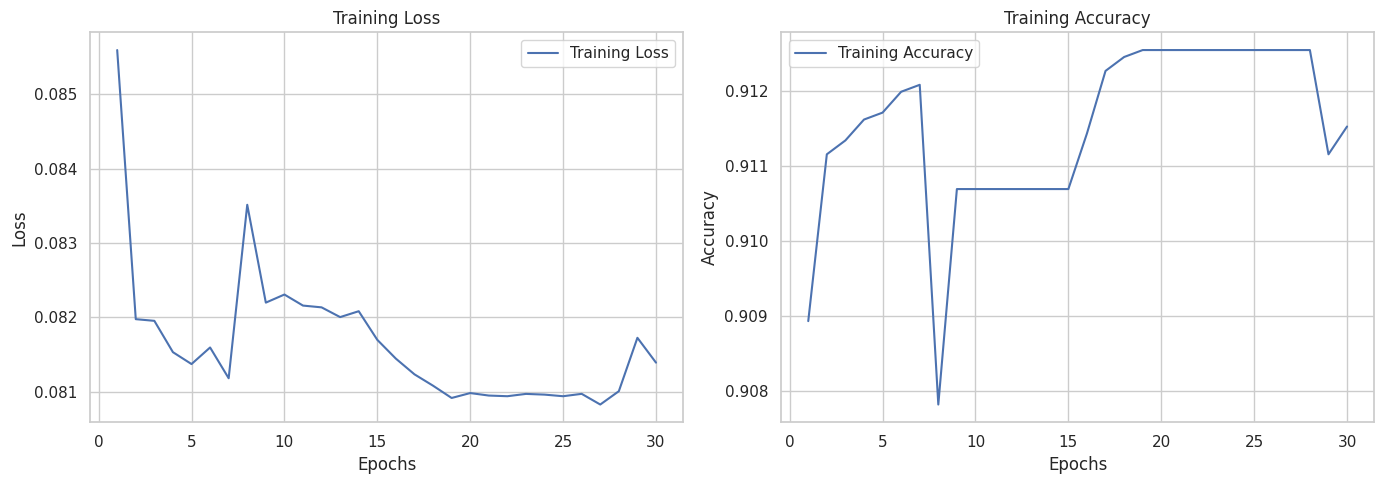

In [230]:
hf.plot_history(history, '3_pair/LSTM/lstm_inbalanced_history')

In [231]:
results_df3.loc[len(results_df3)] = ['3', 'LSTM', False, hf.f1(labels_3p_test, predictions), hf.mean_f1(labels_3p_test, predictions)]
results_df3

Tokenization     Model  Balanced  F1-score  Mean F1-score
0            3  Baseline     False  0.024590       0.489233
1            3  Baseline      True  0.172575       0.428063
2            3      LSTM     False  0.000000       0.478378

* Fit into balanced data

In [232]:
model_1 = Model(inputs=inputs, outputs=outputs)
model_1.compile(optimizer=tf.keras.optimizers.AdamW(), loss='binary_focal_crossentropy', metrics=['accuracy'])

In [233]:
history = model_1.fit(sequences_3p_train_balanced, labels_3p_train_balanced, epochs=30, batch_size=25)

Epoch 1/30
78/78 [==============================] - 10s 103ms/step - loss: 0.2256 - accuracy: 0.4984
Epoch 2/30
78/78 [==============================] - 7s 93ms/step - loss: 0.1733 - accuracy: 0.4891
Epoch 3/30
78/78 [==============================] - 6s 81ms/step - loss: 0.1721 - accuracy: 0.5005
Epoch 4/30
78/78 [==============================] - 7s 87ms/step - loss: 0.1715 - accuracy: 0.4964
Epoch 5/30
78/78 [==============================] - 6s 77ms/step - loss: 0.1710 - accuracy: 0.5155
Epoch 6/30
78/78 [==============================] - 7s 84ms/step - loss: 0.1713 - accuracy: 0.5000
Epoch 7/30
78/78 [==============================] - 6s 72ms/step - loss: 0.1706 - accuracy: 0.5337
Epoch 8/30
78/78 [==============================] - 6s 75ms/step - loss: 0.1704 - accuracy: 0.5218
Epoch 9/30
78/78 [==============================] - 5s 70ms/step - loss: 0.1720 - accuracy: 0.5124
Epoch 10/30
78/78 [==============================] - 5s 62ms/step - loss: 0.1714 - accuracy: 0.4974
Epoch 1

In [234]:
predictions = model_1.predict(sequences_3p_test)

85/85 [==============================] - 2s 18ms/step


In [235]:
predictions = hf.model_accuracy(labels_3p_test, predictions)

Accuracy:  0.8704663212435233
Mean F1 Score:  0.5046408816627556
F1 Score:  0.07894736842105263
Loss:  0.7524


In [236]:
hf.class_report(labels_3p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      0.94      0.93      2478
    Positive       0.10      0.07      0.08       224

    accuracy                           0.87      2702
   macro avg       0.51      0.51      0.50      2702
weighted avg       0.85      0.87      0.86      2702



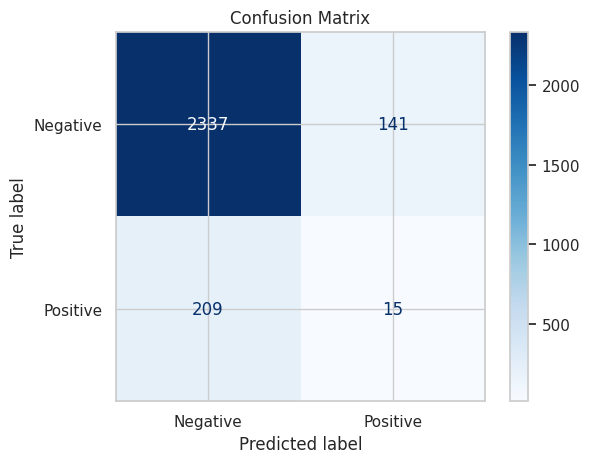

In [237]:
hf.conf_matrix(labels_3p_test, predictions, '3_pair/LSTM/lstm_balanced_cm')

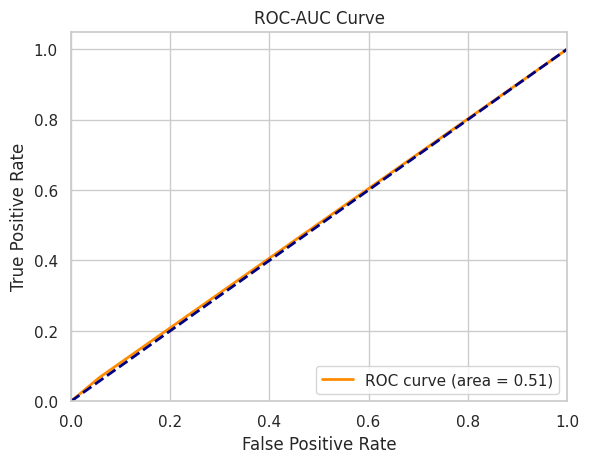

In [238]:
hf.roc_auc_curve(labels_3p_test, predictions, '3_pair/LSTM/lstm_balanced_roc_auc')

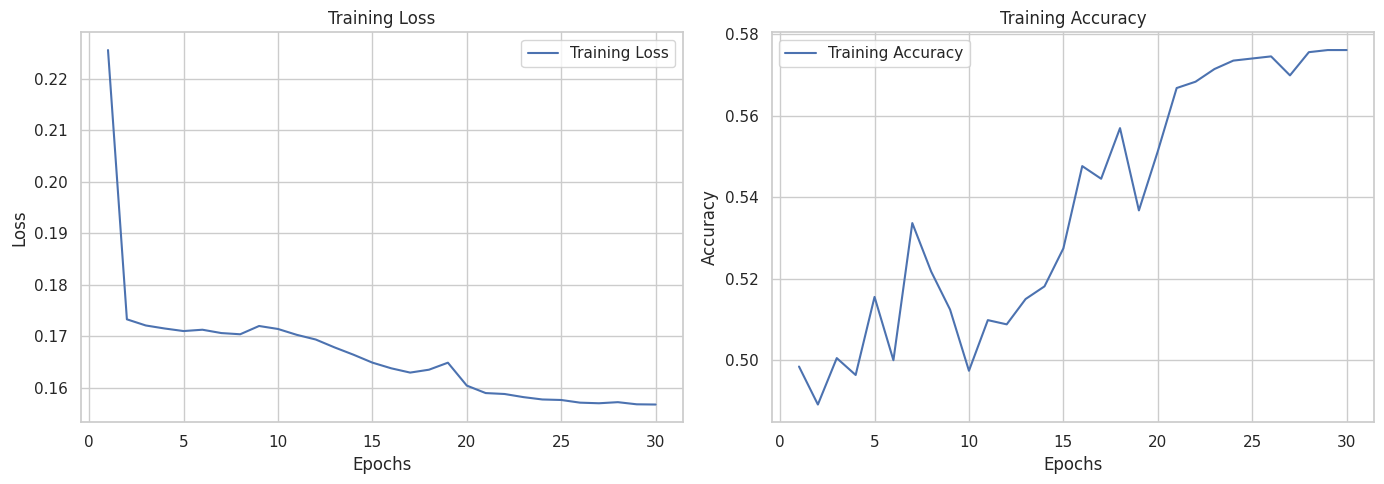

In [239]:
hf.plot_history(history, '3_pair/LSTM/lstm_balanced_history')

In [240]:
results_df3.loc[len(results_df3)] = ['3', 'LSTM', True, hf.f1(labels_3p_test, predictions), hf.mean_f1(labels_3p_test, predictions)]
results_df3

Tokenization     Model  Balanced  F1-score  Mean F1-score
0            3  Baseline     False  0.024590       0.489233
1            3  Baseline      True  0.172575       0.428063
2            3      LSTM     False  0.000000       0.478378
3            3      LSTM      True  0.078947       0.504641

### Transformer

* Model Initialization

In [241]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')

x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)
x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)

attention = MultiHeadAttention(num_heads=10, key_dim=embedding_dim, name='Attention1')(x, x)
attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm2')(x + dense)

x = GlobalAveragePooling1D(name='GAPooling1D')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [242]:
transformer_3 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_3.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=["accuracy"])

In [243]:
transformer_3.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 333)]                0         []                            
                                                                                                  
 Embeddings (Embedding)      (None, 333, 500)             4238000   ['Input[0][0]']               
                                                                                                  
 positional_encoding_4 (Pos  (None, 333, 500)             0         ['Embeddings[0][0]']          
 itionalEncoding)                                                                                 
                                                                                                  
 Attention1 (MultiHeadAtten  (None, 333, 500)             1001550   ['positional_encoding_4

* Fit into inbalanced data

In [244]:
history = transformer_3.fit(sequences_3p_train, labels_3p_train, epochs=30, batch_size=32)

Epoch 1/30
338/338 [==============================] - 51s 145ms/step - loss: 0.3850 - accuracy: 0.9068
Epoch 2/30
338/338 [==============================] - 43s 129ms/step - loss: 0.3067 - accuracy: 0.9107
Epoch 3/30
338/338 [==============================] - 40s 119ms/step - loss: 0.3061 - accuracy: 0.9107
Epoch 4/30
338/338 [==============================] - 37s 109ms/step - loss: 0.3051 - accuracy: 0.9107
Epoch 5/30
338/338 [==============================] - 37s 110ms/step - loss: 0.3039 - accuracy: 0.9107
Epoch 6/30
338/338 [==============================] - 36s 107ms/step - loss: 0.3037 - accuracy: 0.9107
Epoch 7/30
338/338 [==============================] - 35s 105ms/step - loss: 0.3022 - accuracy: 0.9107
Epoch 8/30
338/338 [==============================] - 35s 104ms/step - loss: 0.3028 - accuracy: 0.9107
Epoch 9/30
338/338 [==============================] - 35s 102ms/step - loss: 0.2848 - accuracy: 0.9099
Epoch 10/30
338/338 [==============================] - 34s 100ms/step - l

In [245]:
predictions = transformer_3.predict(sequences_3p_test)

85/85 [==============================] - 3s 36ms/step


In [246]:
predictions = hf.model_accuracy(labels_3p_test, predictions)

Accuracy:  0.8615840118430792
Mean F1 Score:  0.5392366601556444
F1 Score:  0.15384615384615385
Loss:  1.105


In [247]:
hf.class_report(labels_3p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      0.93      0.92      2478
    Positive       0.16      0.15      0.15       224

    accuracy                           0.86      2702
   macro avg       0.54      0.54      0.54      2702
weighted avg       0.86      0.86      0.86      2702



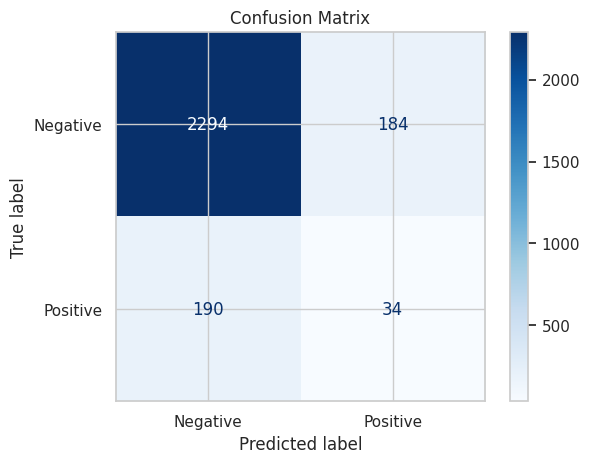

In [248]:
hf.conf_matrix(labels_3p_test, predictions, '3_pair/Transformer/transformer_inbalanced_cm')

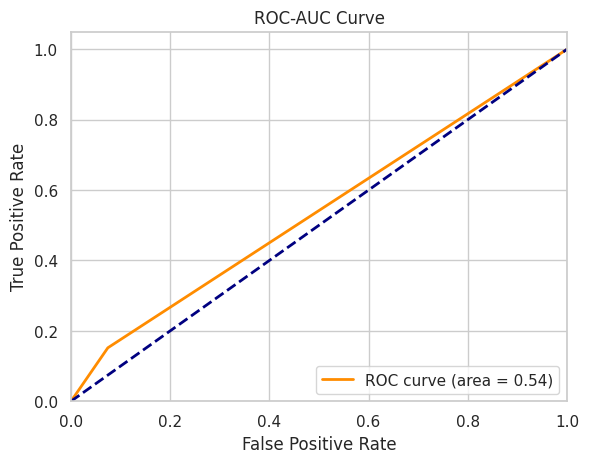

In [249]:
hf.roc_auc_curve(labels_3p_test, predictions, '3_pair/Transformer/transformer_inbalanced_roc_auc')

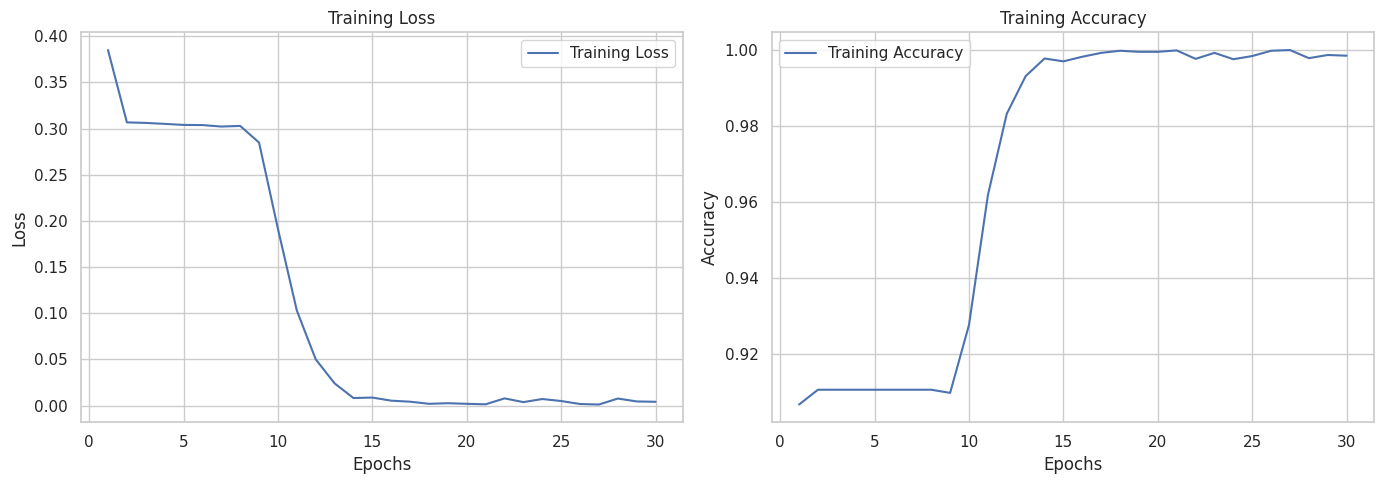

In [250]:
hf.plot_history(history, '3_pair/Transformer/transformer_inbalanced_history')

In [251]:
results_df3.loc[len(results_df3)] = ['3', 'Transformer', False, hf.f1(labels_3p_test, predictions), hf.mean_f1(labels_3p_test, predictions)]
results_df3

Tokenization        Model  Balanced  F1-score  Mean F1-score
0            3     Baseline     False  0.024590       0.489233
1            3     Baseline      True  0.172575       0.428063
2            3         LSTM     False  0.000000       0.478378
3            3         LSTM      True  0.078947       0.504641
4            3  Transformer     False  0.153846       0.539237

* Fit into balanced data

In [252]:
transformer_3 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_3.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=["accuracy"])

In [253]:
history = transformer_3.fit(sequences_3p_train_balanced, labels_3p_train_balanced, epochs=30, batch_size=32)

Epoch 1/30
61/61 [==============================] - 11s 145ms/step - loss: 0.0084 - accuracy: 0.9984
Epoch 2/30
61/61 [==============================] - 8s 138ms/step - loss: 0.0044 - accuracy: 0.9990
Epoch 3/30
61/61 [==============================] - 8s 131ms/step - loss: 8.4178e-04 - accuracy: 0.9995
Epoch 4/30
61/61 [==============================] - 8s 135ms/step - loss: 7.4293e-05 - accuracy: 1.0000
Epoch 5/30
61/61 [==============================] - 8s 128ms/step - loss: 2.4358e-05 - accuracy: 1.0000
Epoch 6/30
61/61 [==============================] - 8s 132ms/step - loss: 1.7750e-05 - accuracy: 1.0000
Epoch 7/30
61/61 [==============================] - 8s 129ms/step - loss: 1.4386e-05 - accuracy: 1.0000
Epoch 8/30
61/61 [==============================] - 8s 131ms/step - loss: 1.1527e-05 - accuracy: 1.0000
Epoch 9/30
61/61 [==============================] - 7s 122ms/step - loss: 1.0480e-05 - accuracy: 1.0000
Epoch 10/30
61/61 [==============================] - 8s 133ms/step - lo

In [254]:
predictions = transformer_3.predict(sequences_3p_test)

85/85 [==============================] - 3s 35ms/step


In [255]:
predictions = hf.model_accuracy(labels_3p_test, predictions)

Accuracy:  0.8182827535159142
Mean F1 Score:  0.5293977010515711
F1 Score:  0.1606837606837607
Loss:  1.655


In [256]:
hf.class_report(labels_3p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      0.87      0.90      2478
    Positive       0.13      0.21      0.16       224

    accuracy                           0.82      2702
   macro avg       0.53      0.54      0.53      2702
weighted avg       0.86      0.82      0.84      2702



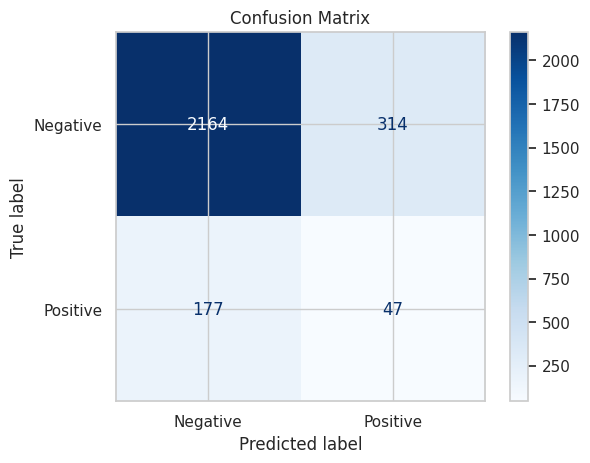

In [257]:
hf.conf_matrix(labels_3p_test, predictions, '3_pair/Transformer/transformer_balanced_cm')

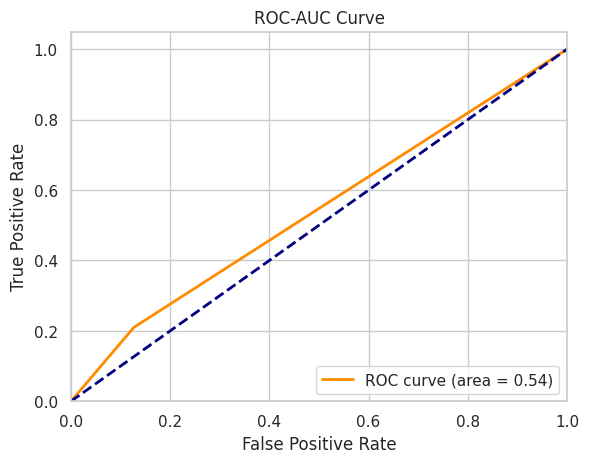

In [258]:
hf.roc_auc_curve(labels_3p_test, predictions, '3_pair/Transformer/transformer_balanced_roc_auc')

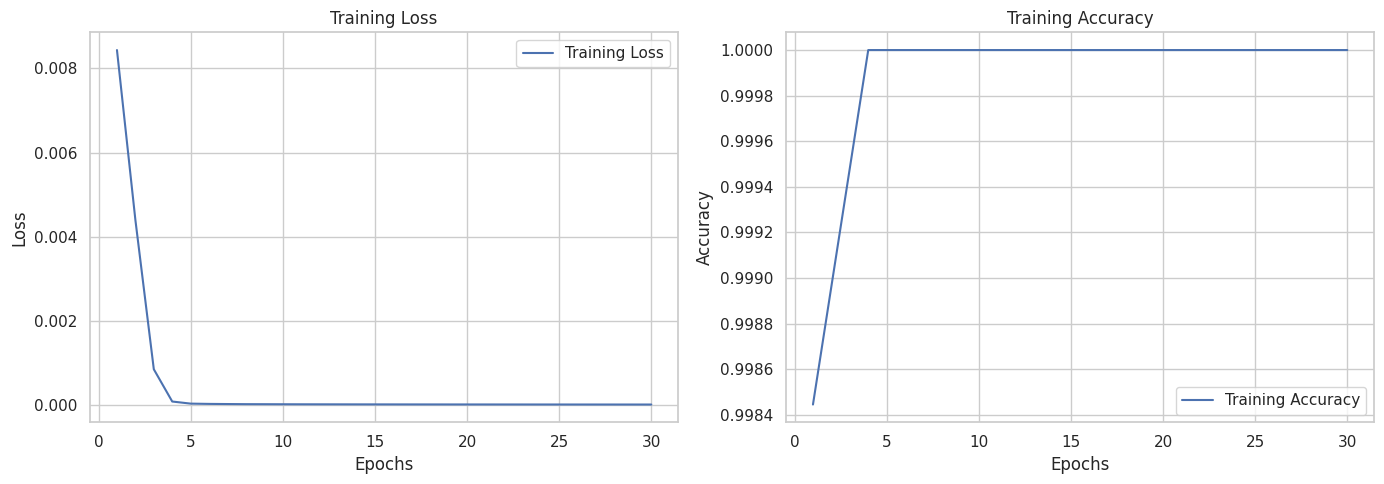

In [259]:
hf.plot_history(history, '3_pair/Transformer/transformer_balanced_history')

In [260]:
results_df3.loc[len(results_df3)] = ['3', 'Transformer', True, hf.f1(labels_3p_test, predictions), hf.mean_f1(labels_3p_test, predictions)]
results_df3

Tokenization        Model  Balanced  F1-score  Mean F1-score
0            3     Baseline     False  0.024590       0.489233
1            3     Baseline      True  0.172575       0.428063
2            3         LSTM     False  0.000000       0.478378
3            3         LSTM      True  0.078947       0.504641
4            3  Transformer     False  0.153846       0.539237
5            3  Transformer      True  0.160684       0.529398

### CNN Transformer

* Model Initialisation

In [261]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')
input_layer = Reshape((sequence_len, 1))(input_layer)

cnn1 = Conv1D(filters=embedding_dim, kernel_size=6, padding='same', activation='relu', name='Conv1D_1')(input_layer)
max_pool1 = MaxPooling1D(pool_size=2, name='MaxPooling1D_1')(cnn1)
# cnn2 = Conv1D(filters=embedding_dim, kernel_size=6, padding='same', activation='relu', name='Conv1D_2')(max_pool1)
# max_pool2 = MaxPooling1D(pool_size=2, name='MaxPooling1D_2')(cnn2)

x = PositionalEncoding(position=sequence_len // 2, d_model=embedding_dim)(max_pool1)


attention = MultiHeadAttention(num_heads=10, key_dim=embedding_dim, name='Attention_1')(x, x)
attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm_1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense_1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense_2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm_2')(x + dense)
x = GlobalAveragePooling1D(name='GAPooling1D')(x)
x = Dropout(0.1, name='Dropout')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [262]:
cnn_transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
cnn_transformer_1.compile(optimizer=tf.keras.optimizers.AdamW(),
                          loss="binary_focal_crossentropy",
                          metrics=['accuracy'])

In [263]:
cnn_transformer_1.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 333, 1)]             0         []                            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 333, 500)             3500      ['input_5[0][0]']             
                                                                                                  
 MaxPooling1D_1 (MaxPooling  (None, 166, 500)             0         ['Conv1D_1[1][0]']            
 1D)                                                                                              
                                                                                                  
 positional_encoding_5 (Pos  (None, 166, 500)             0         ['MaxPooling1D_1[1][0]'

* Fit into inbalanced data

In [264]:
history = cnn_transformer_1.fit(sequences_3p_train, labels_3p_train, epochs=30, batch_size=32)

Epoch 1/30
338/338 [==============================] - 19s 50ms/step - loss: nan - accuracy: 0.9082
Epoch 2/30
338/338 [==============================] - 16s 49ms/step - loss: nan - accuracy: 0.9107
Epoch 3/30
338/338 [==============================] - 17s 50ms/step - loss: nan - accuracy: 0.9107
Epoch 4/30
338/338 [==============================] - 17s 49ms/step - loss: nan - accuracy: 0.9107
Epoch 5/30
338/338 [==============================] - 16s 49ms/step - loss: nan - accuracy: 0.9107
Epoch 6/30
338/338 [==============================] - 17s 50ms/step - loss: nan - accuracy: 0.9107
Epoch 7/30
338/338 [==============================] - 16s 49ms/step - loss: nan - accuracy: 0.9107
Epoch 8/30
338/338 [==============================] - 18s 53ms/step - loss: nan - accuracy: 0.9107
Epoch 9/30
338/338 [==============================] - 16s 48ms/step - loss: nan - accuracy: 0.9107
Epoch 10/30
338/338 [==============================] - 16s 49ms/step - loss: nan - accuracy: 0.9107
Epoch 11/

In [265]:
predictions = cnn_transformer_1.predict(sequences_3p_test)

85/85 [==============================] - 2s 18ms/step


In [266]:
predictions = hf.model_accuracy(labels_3p_test, predictions)

Accuracy:  0.917098445595855
Mean F1 Score:  0.4783783783783784
F1 Score:  0.0
Loss:  nan


In [267]:
hf.class_report(labels_3p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96      2478
    Positive       0.00      0.00      0.00       224

    accuracy                           0.92      2702
   macro avg       0.46      0.50      0.48      2702
weighted avg       0.84      0.92      0.88      2702



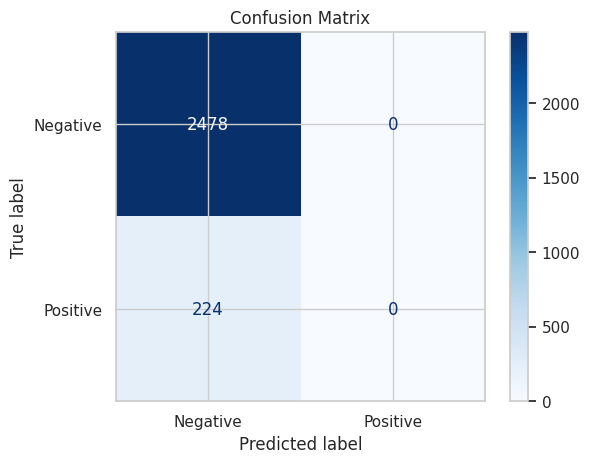

In [268]:
hf.conf_matrix(labels_3p_test, predictions, '3_pair/CNN_Transformer/cnn_transformer_inbalanced_cm')

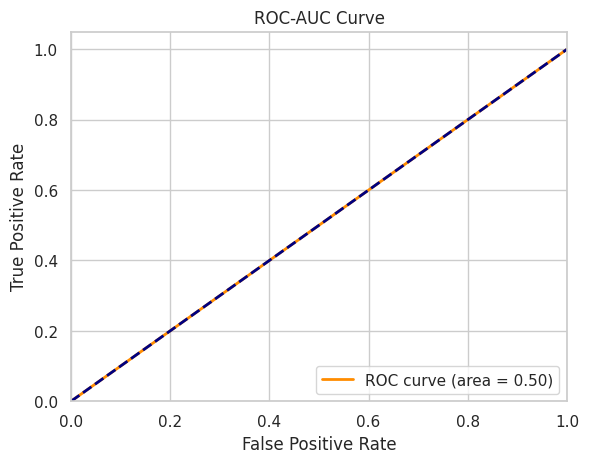

In [269]:
hf.roc_auc_curve(labels_3p_test, predictions, '3_pair/CNN_Transformer/cnn_transformer_inbalanced_roc_auc')

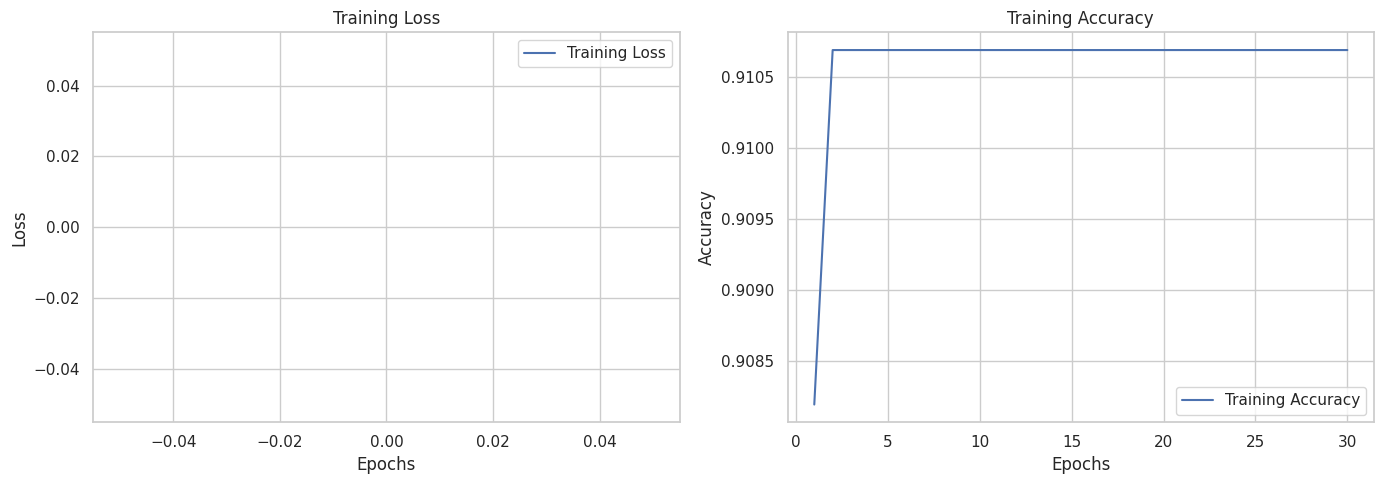

In [270]:
hf.plot_history(history, '3_pair/CNN_Transformer/cnn_transformer_inbalanced_history')

In [271]:
results_df3.loc[len(results_df3)] = ['3', 'CNN_Transformer', False, hf.f1(labels_3p_test, predictions), hf.mean_f1(labels_3p_test, predictions)]
results_df3

Tokenization            Model  Balanced  F1-score  Mean F1-score
0            3         Baseline     False  0.024590       0.489233
1            3         Baseline      True  0.172575       0.428063
2            3             LSTM     False  0.000000       0.478378
3            3             LSTM      True  0.078947       0.504641
4            3      Transformer     False  0.153846       0.539237
5            3      Transformer      True  0.160684       0.529398
6            3  CNN_Transformer     False  0.000000       0.478378

* Fit into balanced data

In [272]:
cnn_transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
cnn_transformer_1.compile(optimizer=tf.keras.optimizers.AdamW(),
                          loss="binary_focal_crossentropy",
                          metrics=['accuracy'])
history = cnn_transformer_1.fit(sequences_3p_train_balanced, labels_3p_train_balanced, epochs=30, batch_size=32)

Epoch 1/30
61/61 [==============================] - 5s 55ms/step - loss: nan - accuracy: 0.5000
Epoch 2/30
61/61 [==============================] - 3s 47ms/step - loss: nan - accuracy: 0.5000
Epoch 3/30
61/61 [==============================] - 3s 47ms/step - loss: nan - accuracy: 0.5000
Epoch 4/30
61/61 [==============================] - 3s 47ms/step - loss: nan - accuracy: 0.5000
Epoch 5/30
61/61 [==============================] - 3s 47ms/step - loss: nan - accuracy: 0.5000
Epoch 6/30
61/61 [==============================] - 3s 47ms/step - loss: nan - accuracy: 0.5000
Epoch 7/30
61/61 [==============================] - 3s 47ms/step - loss: nan - accuracy: 0.5000
Epoch 8/30
61/61 [==============================] - 3s 47ms/step - loss: nan - accuracy: 0.5000
Epoch 9/30
61/61 [==============================] - 3s 48ms/step - loss: nan - accuracy: 0.5000
Epoch 10/30
61/61 [==============================] - 3s 48ms/step - loss: nan - accuracy: 0.5000
Epoch 11/30
61/61 [====================

In [273]:
predictions = cnn_transformer_1.predict(sequences_3p_test)

85/85 [==============================] - 2s 17ms/step


In [274]:
predictions = hf.model_accuracy(labels_3p_test, predictions)

Accuracy:  0.917098445595855
Mean F1 Score:  0.4783783783783784
F1 Score:  0.0
Loss:  nan


In [275]:
hf.class_report(labels_3p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96      2478
    Positive       0.00      0.00      0.00       224

    accuracy                           0.92      2702
   macro avg       0.46      0.50      0.48      2702
weighted avg       0.84      0.92      0.88      2702



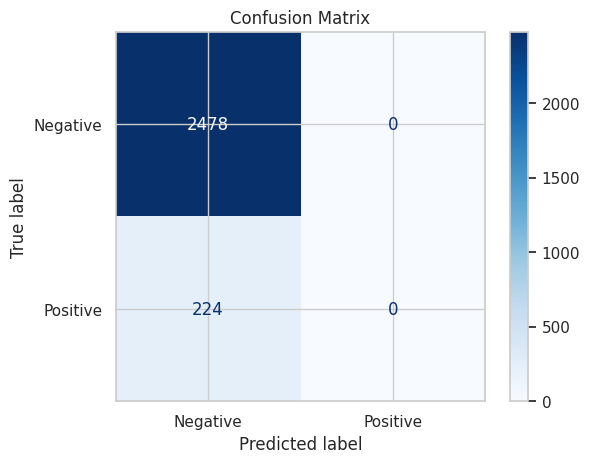

In [276]:
hf.conf_matrix(labels_3p_test, predictions, '3_pair/CNN_Transformer/cnn_transformer_balanced_cm')

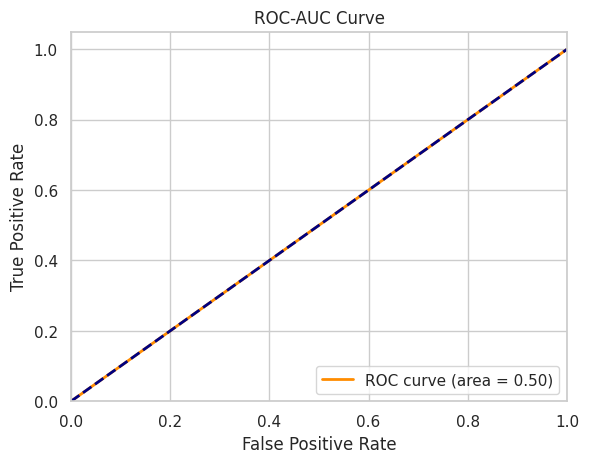

In [277]:
hf.roc_auc_curve(labels_3p_test, predictions, '3_pair/CNN_Transformer/cnn_transformer_balanced_roc_auc')

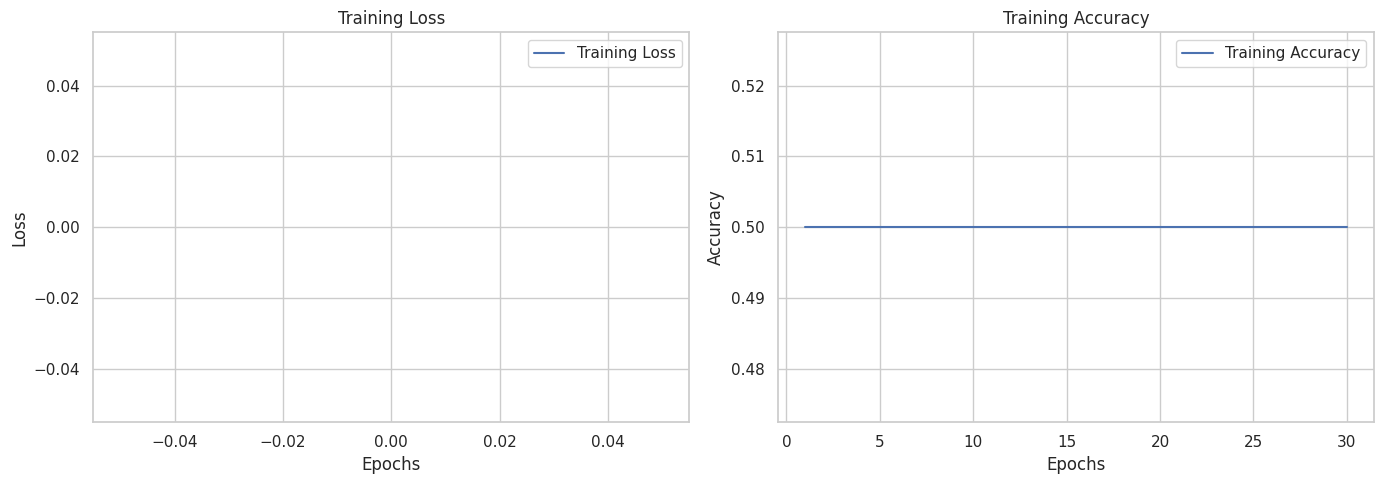

In [278]:
hf.plot_history(history, '3_pair/CNN_Transformer/cnn_transformer_balanced_history')

In [279]:
results_df3.loc[len(results_df3)] = ['3', 'CNN_Transformer', True, hf.f1(labels_3p_test, predictions), hf.mean_f1(labels_3p_test, predictions)]
results_df3

Tokenization            Model  Balanced  F1-score  Mean F1-score
0            3         Baseline     False  0.024590       0.489233
1            3         Baseline      True  0.172575       0.428063
2            3             LSTM     False  0.000000       0.478378
3            3             LSTM      True  0.078947       0.504641
4            3      Transformer     False  0.153846       0.539237
5            3      Transformer      True  0.160684       0.529398
6            3  CNN_Transformer     False  0.000000       0.478378
7            3  CNN_Transformer      True  0.000000       0.478378

### Results

In [280]:
results_df3

Tokenization            Model  Balanced  F1-score  Mean F1-score
0            3         Baseline     False  0.024590       0.489233
1            3         Baseline      True  0.172575       0.428063
2            3             LSTM     False  0.000000       0.478378
3            3             LSTM      True  0.078947       0.504641
4            3      Transformer     False  0.153846       0.539237
5            3      Transformer      True  0.160684       0.529398
6            3  CNN_Transformer     False  0.000000       0.478378
7            3  CNN_Transformer      True  0.000000       0.478378

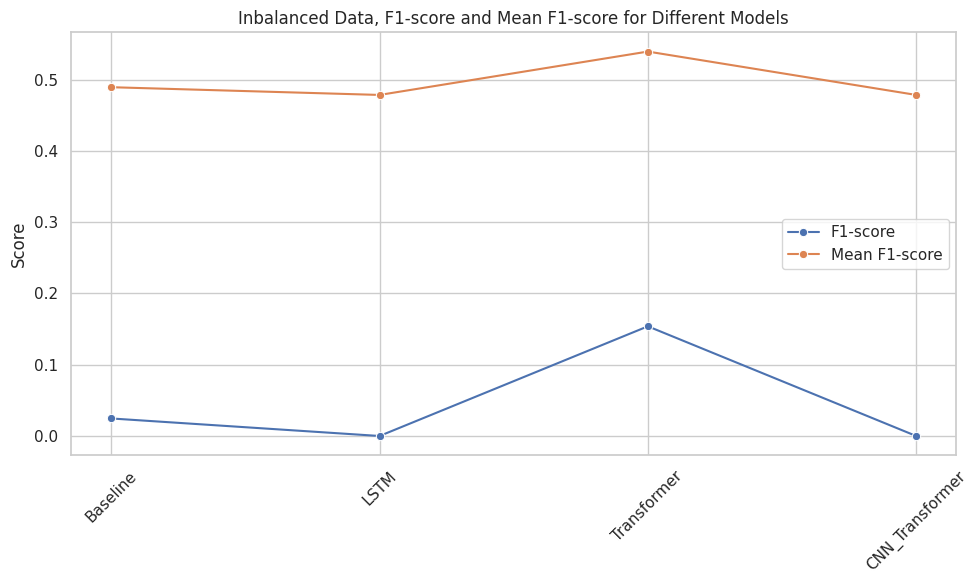

In [281]:
inbalanced_df = results_df3[results_df3['Balanced'] == False]

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=inbalanced_df, x='Model', y='F1-score', marker='o', label='F1-score')
sns.lineplot(data=inbalanced_df, x='Model', y='Mean F1-score', marker='o', label='Mean F1-score')

# Customize the plot with titles and labels
plt.title('Inbalanced Data, F1-score and Mean F1-score for Different Models')
plt.xlabel(None)
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig('Figures/Modeling/3_pair/Inbalanced_data_results.png')
plt.show()

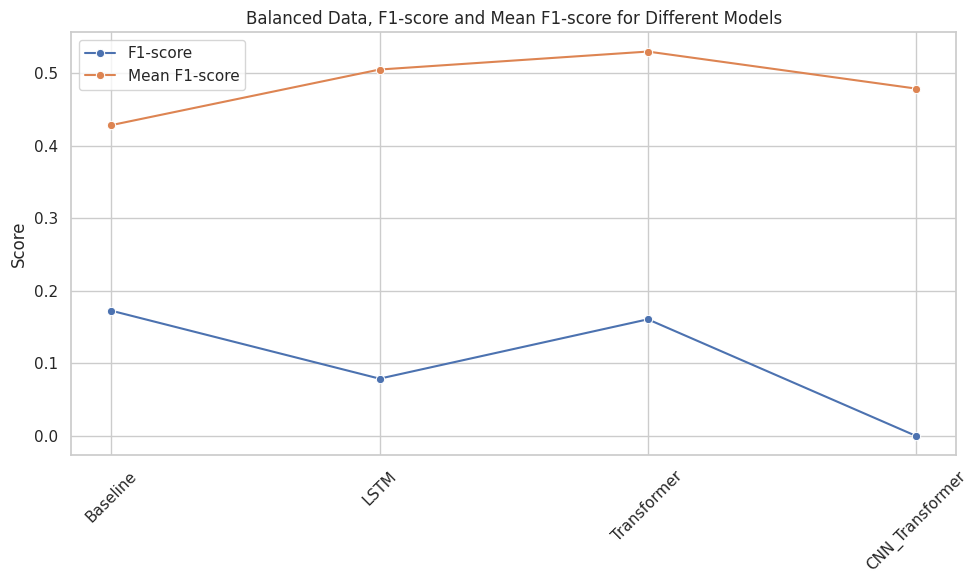

In [282]:
balanced_df = results_df3[results_df3['Balanced'] == True]

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=balanced_df, x='Model', y='F1-score', marker='o', label='F1-score')
sns.lineplot(data=balanced_df, x='Model', y='Mean F1-score', marker='o', label='Mean F1-score')

# Customize the plot with titles and labels
plt.title('Balanced Data, F1-score and Mean F1-score for Different Models')
plt.xlabel(None)
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig('Figures/Modeling/3_pair/Balanced_data_results.png')
plt.show()

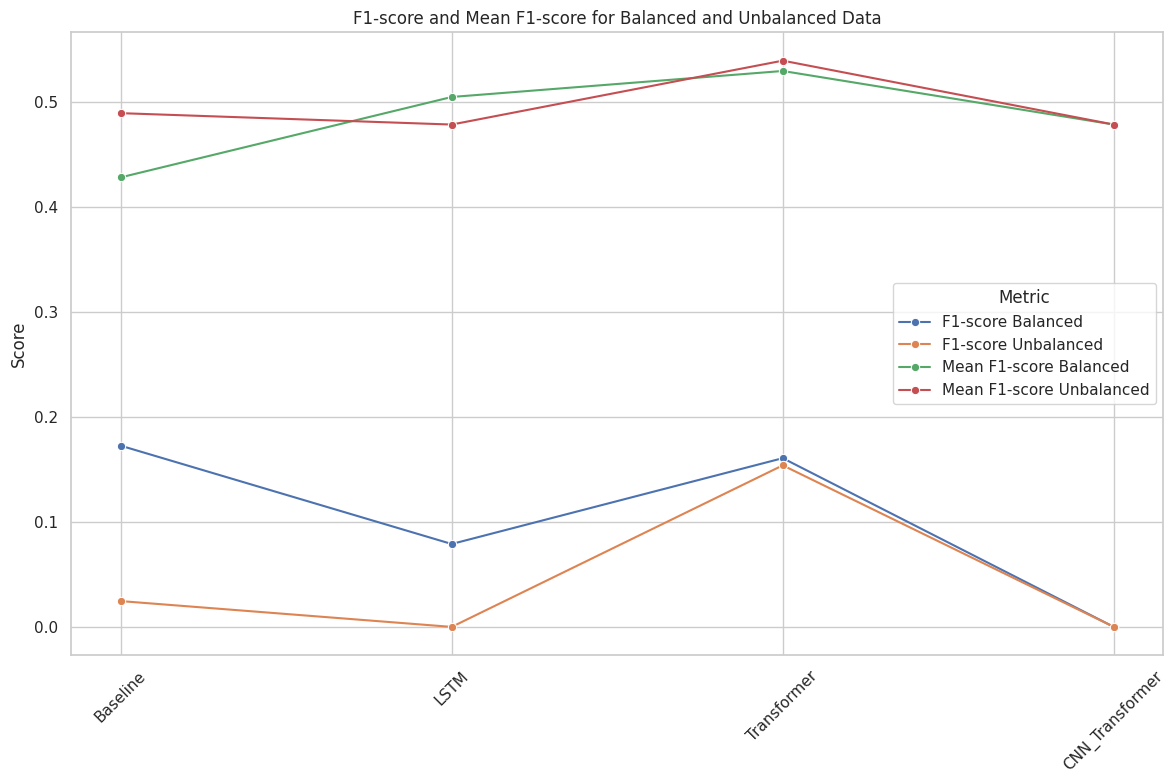

In [283]:
results_df3['F1-score_Balanced'] = results_df3.apply(lambda row: row['F1-score'] if row['Balanced'] else None, axis=1)
results_df3['F1-score_Unbalanced'] = results_df3.apply(lambda row: row['F1-score'] if not row['Balanced'] else None, axis=1)
results_df3['Mean_F1-score_Balanced'] = results_df3.apply(lambda row: row['Mean F1-score'] if row['Balanced'] else None, axis=1)
results_df3['Mean_F1-score_Unbalanced'] = results_df3.apply(lambda row: row['Mean F1-score'] if not row['Balanced'] else None, axis=1)

# Plot the data
plt.figure(figsize=(12, 8))

# Plot each line separately
sns.lineplot(data=results_df3, x='Model', y='F1-score_Balanced', marker='o', label='F1-score Balanced')
sns.lineplot(data=results_df3, x='Model', y='F1-score_Unbalanced', marker='o', label='F1-score Unbalanced')
sns.lineplot(data=results_df3, x='Model', y='Mean_F1-score_Balanced', marker='o', label='Mean F1-score Balanced')
sns.lineplot(data=results_df3, x='Model', y='Mean_F1-score_Unbalanced', marker='o', label='Mean F1-score Unbalanced')

# Customize the plot with titles and labels
plt.title('F1-score and Mean F1-score for Balanced and Unbalanced Data')
plt.xlabel(None)
plt.ylabel('Score')
plt.legend(title='Metric', loc='center right')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig('Figures/Modeling/3_pair/Results.png')
plt.show()

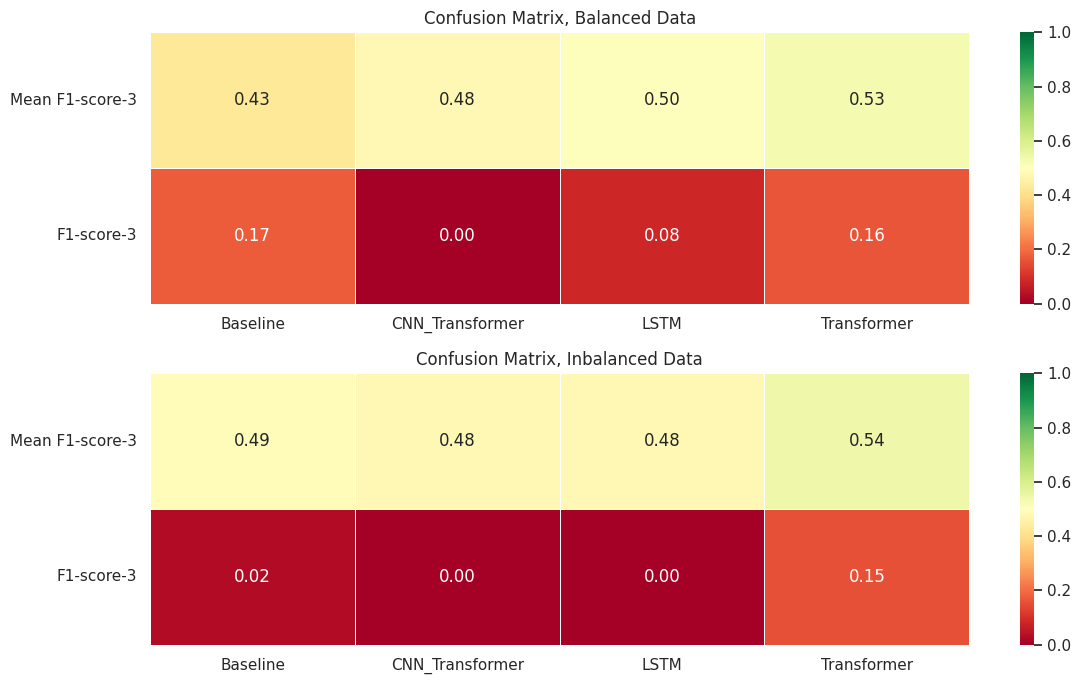

In [284]:
# Create confusion matrix for Balanced=True
conf_matrix_balanced_true = balanced_df.pivot(index='Model',
                                              columns='Tokenization',
                                              values=['Mean F1-score', 'F1-score']).T

# Create confusion matrix for Balanced=False
conf_matrix_balanced_false = inbalanced_df.pivot(index='Model',
                                                 columns='Tokenization',
                                                 values=['Mean F1-score', 'F1-score']).T

# Plot the confusion matrixes
fig, axs = plt.subplots(2, 1, figsize=(12, 7))

# Confusion matrix for Balanced=True
sns.heatmap(conf_matrix_balanced_true, annot=True, fmt=".2f", cmap="RdYlGn", cbar=True, linewidths=0.5, vmin=0, vmax=1, ax=axs[0])
axs[0].set_title('Confusion Matrix, Balanced Data')
axs[0].set_xlabel(None)
axs[0].set_ylabel(None)
axs[0].tick_params(axis='y', labelrotation=0)

# Confusion matrix for Balanced=False
sns.heatmap(conf_matrix_balanced_false, annot=True, fmt=".2f", cmap="RdYlGn", cbar=True, linewidths=0.5, vmin=0, vmax=1, ax=axs[1])
axs[1].set_title('Confusion Matrix, Inbalanced Data')
axs[1].set_xlabel(None)
axs[1].set_ylabel(None)
axs[1].tick_params(axis='y', labelrotation=0)

plt.tight_layout()
plt.savefig('Figures/Modeling/3_pair/Results_cm.png')
plt.show()